# Preparing

In [1]:
import logging
import json
import gc
import os
import pickle
import joblib
import re
import math
import warnings
import string
from datetime import timedelta, datetime
from itertools import combinations, groupby

import numpy as np
import pandas as pd
import boto3
from io import BytesIO
from pandas.errors import PerformanceWarning

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

from feature_engine.encoding.rare_label import RareLabelEncoder
from feature_engine.encoding import WoEEncoder
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures,
    SelectByTargetMeanPerformance
)

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    accuracy_score,
    auc,
    log_loss,
    make_scorer,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)

from optbinning import OptimalBinning

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [2]:
# import from transformers

from transformers.helpers import (
    add_ww_mm_date, 
    df_filter_by_dts,
)

from transformers.constants import (
    DT_LABEL,
    TS_COL,
    TARGET,
    MISSING,
    NAN,
    OTHER,
    CAT,
    NUM,
    BIN,
    WOE,
    SEP,
    GROUPS,
    DT_START,
    DT_END,
)

from transformers.logger import logger

from transformers.preparing import (
    read_data,
    compute_salary_median,
    parse_dates,
    calculate_age_experience
)

In [3]:
from transformers.simple_features_transformer import SimpleFeaturesTransformer

from transformers.py_classes import (
    BinningCategoriesTransformer_collection,
    BinningNumericalTransformer_collection,
    WoeEncoderTransformer_collection,
    FeatureEliminationTransformer,
    CustomRareCategoriesTransformer,
    CustomLogisticRegressionClassifier,
)

# Read and prepare data

## Read full parsed DataFrame

In [4]:
# --- Synthetic data ---
# This replaces any proprietary data loading.
# The dataset mimics a collections / payments use case with:
# - customer attributes
# - collection activity signals
# - credit bureau style aggregates
# - risk / arrears signals
#
# Targets:
# - target: payment event (0/1)

import numpy as np
import pandas as pd

np.random.seed(42)

N = 120000
TARGET = "target"

# ------------------------------------------------------------------
# Helper generators
# ------------------------------------------------------------------
def choice(vals, p=None):
    return np.random.choice(vals, size=N, p=p)

def lognorm(mu, sigma):
    return np.random.lognormal(mean=mu, sigma=sigma, size=N)

# ------------------------------------------------------------------
# Base dataframe
# ------------------------------------------------------------------
df_sample = pd.DataFrame({
    "loan_id": np.arange(N),
    "snap_date": pd.to_datetime("2025-01-01")
        + pd.to_timedelta(np.random.randint(0, 150, size=N), unit="D"),

    # -------------------- categorical --------------------
    "loan_name": choice(["Product_A", "Product_B", "Product_C"], p=[0.45, 0.35, 0.20]),
    "customer.addressLGA": choice(["LGA_1", "LGA_2", "LGA_3", "LGA_4", "LGA_5"]),
    "customer.employment.employerLGA": choice(["LGA_1", "LGA_2", "LGA_3", "LGA_4", "LGA_5"]),
    "customer.employment.businessSector": choice(["Retail", "Services", "Manufacturing", "Public", "Other"]),
    "application.existingCustomer": choice(["Y", "N"], p=[0.55, 0.45]),
    "application.loanType": choice(["Type_1", "Type_2", "Type_3"]),
    "application.lastLoanStatus": choice(
        ["Paid", "Default", "Active", "Unknown"], p=[0.45, 0.10, 0.30, 0.15]
    ),
    "application.employmentSector": choice(
        ["Retail", "Services", "Manufacturing", "Public", "Other"]
    ),
    "application.employmentStatus": choice(
        ["Employed", "Self-Employed", "Unemployed"], p=[0.68, 0.18, 0.14]
    ),
    "application.maritalStatus": choice(
        ["Single", "Married", "Divorced", "Other"], p=[0.48, 0.44, 0.06, 0.02]
    ),
    "bvn.stateOfOrigin": choice(
        ["State_1", "State_2", "State_3", "State_4", "State_5"]
    ),
    "cb_avg.highestRepaymentStatus": choice(
        ["Good", "Neutral", "Bad", "Unknown"], p=[0.65, 0.20, 0.08, 0.07]
    ),
    "gender": choice(["M", "F"], p=[0.55, 0.45]),
    "labeling": choice(["segment_A", "segment_B", "segment_C"], p=[0.40, 0.35, 0.25]),

    # -------------------- numeric --------------------
    "application.requestedLoanAmount": lognorm(10.2, 0.45),
    "total_payment": lognorm(9.2, 0.7),
    "promised_amount": lognorm(9.0, 0.8),
    "salary_median": lognorm(10.1, 0.5),

    "daily_arrearsprincipal": lognorm(8.6, 0.9),
    "daily_arrearsinterest": lognorm(7.8, 1.0),
    "daily_penaltydue": lognorm(7.2, 1.1),

    "cb_avg.outstandingloan": lognorm(10.3, 0.55),
    "cb_avg.totalMonthlyInstallments": lognorm(9.4, 0.6),

    "keptpromise_ratio": np.random.beta(2, 6, size=N),
    "ptp_amount_paid_ratio": np.random.beta(2, 5, size=N),

    "total_contact_flag": np.random.binomial(1, 0.75, size=N),
    "total_contact_flag_coll": np.random.binomial(1, 0.65, size=N),

    "age": np.random.randint(18, 71, size=N),
    "experience": np.random.randint(0, 36, size=N),
})

# ------------------------------------------------------------------
# Integer DAY-based columns: 1..180
# ------------------------------------------------------------------
day_cols = [
    "days_since_last_payment",
    "days_since_last_promise",
    "application.renMaxDPD",
    "cb_avg.currentDPD",
    "cb_avg.maxDPD",
    "days_past_due",
]

for c in day_cols:
    df_sample[c] = np.random.randint(1, 181, size=N)

# ------------------------------------------------------------------
# Integer COUNT-based columns: 0..15
# ------------------------------------------------------------------
count_cols = [
    "loan_num",
    "num_collection",
    "non_null_default_reason_count",
    "total_number_of_payments",
    "total_number_of_promises",
    "overdue_payment_number",
    "cb_avg.noOfLoans",
    "cb_avg.noOfNonPerformingLoans",
    "cb_avg.noOfBadAccounts",
]

for c in count_cols:
    df_sample[c] = np.random.randint(0, 16, size=N)

# ------------------------------------------------------------------
# Overdue bucket
# ------------------------------------------------------------------
df_sample["overdue_bucket"] = pd.cut(
    df_sample["days_past_due"],
    bins=[-1, 0, 30, 60, 90, 180, 360],
    labels=["0_0", "5-30", "30-60", "60-90", "90-180", "180-360"]
)

# ------------------------------------------------------------------
# Latent propensity -> payment probability
# ------------------------------------------------------------------
z = (
    0.9 * (df_sample["application.employmentStatus"].eq("Employed").astype(int))
    + 0.5 * (df_sample["application.existingCustomer"].eq("Y").astype(int))
    + 0.25 * np.log1p(df_sample["total_number_of_payments"])
    - 0.015 * df_sample["days_since_last_payment"]
    - 0.12 * (df_sample["cb_avg.maxDPD"] > 60).astype(int)
    - 0.10 * (df_sample["application.renMaxDPD"] > 60).astype(int)
    + 0.20 * df_sample["keptpromise_ratio"]
    + np.random.normal(0, 0.45, size=N)
)

p_pay = 1 / (1 + np.exp(-z))
df_sample[TARGET] = (np.random.rand(N) < p_pay).astype(int)

df_sample.head()

,loan_id,snap_date,loan_name,customer.addressLGA,customer.employment.employerLGA,customer.employment.businessSector,application.existingCustomer,application.loanType,application.lastLoanStatus,application.employmentSector,...,num_collection,non_null_default_reason_count,total_number_of_payments,total_number_of_promises,overdue_payment_number,cb_avg.noOfLoans,cb_avg.noOfNonPerformingLoans,cb_avg.noOfBadAccounts,overdue_bucket,target
0,0,2025-04-13,Product_B,LGA_3,LGA_1,Services,N,Type_1,Paid,Public,...,11,2,2,11,8,7,4,14,90-180,0
1,1,2025-04-03,Product_C,LGA_5,LGA_5,Other,N,Type_1,Active,Other,...,4,0,11,6,2,15,8,13,60-90,1
2,2,2025-01-15,Product_C,LGA_2,LGA_2,Services,Y,Type_2,Active,Services,...,13,7,3,10,9,1,11,7,90-180,0
3,3,2025-04-17,Product_A,LGA_3,LGA_4,Public,N,Type_2,Unknown,Retail,...,0,5,6,9,5,0,0,5,90-180,1
4,4,2025-03-13,Product_A,LGA_3,LGA_4,Public,Y,Type_3,Paid,Retail,...,10,10,5,7,6,1,8,12,90-180,1


In [5]:
df_sample["target"].value_counts()

0    61951
1    58049
Name: target, dtype: int64

In [6]:
df_sample.rename(columns={"target_flag": "target"}, inplace=True)

## Time features

In [7]:
# Convert necessary columns to datetime
date_columns = ["snap_date"]
df_sample[date_columns] = df_sample[date_columns].apply(pd.to_datetime)

## Split by buckets and product

In [8]:
df_sample["overdue_bucket"].value_counts(dropna = False)

90-180     60137
60-90      19983
30-60      19968
5-30       19912
180-360        0
0_0            0
Name: overdue_bucket, dtype: int64

In [9]:
categories = {
    "PL_ZEUS": [
        "Product_A"
    ],
    "TWO_WEEK": [
        "Product_B"
    ],
    "SEL_BETA": [
        "Product_C"
    ],
}

In [10]:
def clean_bucket_name(bucket):
     return str(bucket).replace('-', '_').replace('+', 'plus')

# Iterate through categories
for category_name, loan_list in categories.items():
    for bucket in df_sample["overdue_bucket"].unique():
        # Filter by loan name and overdue bucket
        df_filtered = df_sample[(df_sample["loan_name"].isin(loan_list)) & (df_sample["overdue_bucket"] == bucket)]
        
        # Create a dynamic name for DataFrame
        df_name = f"df_{category_name}_{clean_bucket_name(bucket)}"
        
        # Store in global space
        globals()[df_name] = df_filtered

# Define your custom merge mapping
merge_map = {
    "df_PL_ZEUS_5_30": ["df_PL_ZEUS_5_30"], 
    "df_PL_ZEUS_30_60": ["df_PL_ZEUS_30_60"], 
    "df_PL_ZEUS_60_360": ["df_PL_ZEUS_60_90", "df_PL_ZEUS_90_180", "df_PL_ZEUS_180_360"],
    
    "df_TWO_WEEK_5_30": ["df_TWO_WEEK_5_30"], 
    "df_TWO_WEEK_30_360": ["df_TWO_WEEK_30_60", 
                           "df_TWO_WEEK_60_90", 
                           "df_TWO_WEEK_90_180", 
                           "df_TWO_WEEK_180_360"],
    
    "df_SEL_BETA_5_30": ["df_SEL_BETA_5_30"],
    "df_SEL_BETA_30_60" : ["df_SEL_BETA_30_60"],
    "df_SEL_BETA_60_360": ["df_SEL_BETA_60_90", "df_SEL_BETA_90_180", "df_SEL_BETA_180_360"]
}

# Combine and summarize
table_results = []

for new_df_name, source_names in merge_map.items():
    combined_dfs = [globals().get(name) for name in source_names if globals().get(name) is not None]
    
    if not combined_dfs:
        print(f"Warning: No valid DataFrames found for {new_df_name}. Skipping.")
        continue

    combined_df = pd.concat(combined_dfs, ignore_index=True)
    globals()[new_df_name] = combined_df

    shape = combined_df.shape
    target_counts = combined_df["target"].value_counts().to_dict()

    table_results.append([
        new_df_name, shape[0], shape[1],
        target_counts.get(0, 0), target_counts.get(1, 0)
    ])

summary_df = pd.DataFrame(table_results, columns=["DataFrame", "Rows", "Cols", "Target 0", "Target 1"])
print(summary_df)

            DataFrame   Rows  Cols  Target 0  Target 1
0     df_PL_ZEUS_5_30   9023    48      4662      4361
1    df_PL_ZEUS_30_60   9017    48      4738      4279
2   df_PL_ZEUS_60_360  35978    48     18588     17390
3    df_TWO_WEEK_5_30   6952    48      3542      3410
4  df_TWO_WEEK_30_360  34999    48     18119     16880
5    df_SEL_BETA_5_30   3937    48      2029      1908
6   df_SEL_BETA_30_60   3983    48      2051      1932
7  df_SEL_BETA_60_360  16111    48      8222      7889


# Modeling 

## Short_term - Month Large Bucket 

In [11]:
df = df_SEL_BETA_5_30.copy()

In [12]:
df.drop(columns=[
    'application.requestedLoanAmount',
], inplace=True)

In [13]:
num_features_dct = {
    #'loan_amount': -1.0,
    #'loan_tenor': -1.0,
    #'loan_amt_x_tenor': -1.0,
    'loan_num': -1.0,
    'num_collection': -1.0,
    'non_null_default_reason_count': -1.0,
    'keptpromise_ratio': -1.0,
    'ptp_amount_paid_ratio': -1.0,
    'total_payment': -1.0,
    "total_number_of_payments": -1.0,
    'total_contact_flag': -1.0,
    'total_contact_flag_coll': -1.0,
    'days_since_last_payment': -1.0,
    #'days_until_next_payment': -1.0, - future
    "promised_amount": -1.0,
    'paid_promised_amount': -1.0,
    "number_of_kept_promises": -1.0,    
    "total_number_of_promises": -1.0,
    "days_since_last_promise": -1.0,
    #"days_since_last_kept_promise": -1.0,
    "overdue_payment_number": -1.0,
    "application.effectiveInterestRate": -1.0,
    #"application.requestedLoanTerm": -1.0,
    "cb_avg.highestLoanRepayment": -1.0,
    'day_from_begin_to_overdue': -1.0,
    'days_past_due': -1.0,
    'loan_balance': -1.0,
    'daily_arrearsprincipal': -1.0,
    'daily_arrearsinterest': -1.0,
    'daily_penaltydue': -1.0,
    'application.renMaxDPD': -1.0,
    'salary_median': -1.0,
    'cb_avg.outstandingloan': -1.0,
    'cb_avg.totalMonthlyInstallments': -1.0,
    'cb_avg.currentDPD': -1.0,
    'cb_avg.maxDPD': -1.0,
    'age': -1.0,
    'experience': -1.0,
    'cb_avg.noOfLoans': -1.0,
    'cb_avg.noOfNonPerformingLoans': -1.0,
    'cb_avg.noOfBadAccounts': -1.0
}

In [14]:
cat_features_dct = {
    'loan_name': MISSING,
    'customer.addressLGA': MISSING,
    'customer.employment.employerLGA': MISSING,
    'customer.employment.businessSector': MISSING,
    'application.existingCustomer': MISSING,
    'application.loanType': MISSING,
    'application.requestedLoanAmount': MISSING,
    'application.lastLoanStatus': MISSING,
    'application.requestedLoanAmount': MISSING,
    'application.employmentSector': MISSING,
    'application.employmentStatus': MISSING,
    'application.maritalStatus': MISSING,
    'bvn.stateOfOrigin': MISSING,
    'application.maritalStatus': MISSING,
    'application.maritalStatus': MISSING,
    'cb_avg.highestRepaymentStatus': MISSING,
    'gender': MISSING,
    'labeling': MISSING
}

In [15]:
flag_features_lst = [
    ]

In [16]:
time_elapsed_features_lst = [
    ]

### Add beg of months and weeks

In [17]:
df[TS_COL] = pd.to_datetime(df[TS_COL], errors='coerce')

In [18]:
df = add_ww_mm_date(df, TS_COL)

### Reset index from 0

In [19]:
df = df.reset_index(drop=True)

In [20]:
gc.collect()

0

### Adjust data types

In [21]:
int_cols = [TARGET]

In [22]:
df[int_cols] = df[int_cols].astype(int)

### Transformations

In [23]:
simple_feature_trans = SimpleFeaturesTransformer(
    num_features_dct,
    cat_features_dct,
    time_elapsed_features_lst,
    flag_features_lst)

df2 = simple_feature_trans.fit_transform(df)

2025-12-17 23:27:26 - INFO - Simple features - Successfully finished.


## Rare cat encoder

In [24]:
custom_rare_cat_trans = CustomRareCategoriesTransformer()

df3 = custom_rare_cat_trans.fit_transform(df2)

2025-12-17 23:27:26 - INFO - Rare categories encoder - fit done
2025-12-17 23:27:26 - INFO - Rare categories encoder - transform done.


## Feature Eliminator

## Binning

### Cat

In [25]:
bicattr = BinningCategoriesTransformer_collection()

bicattr.fit(df3.drop(TARGET, axis=1), df3[TARGET])
df5 = bicattr.transform(df3.drop(TARGET, axis=1), df3[TARGET])

2025-12-17 23:27:26 - INFO - Cat. binning - fit done.
2025-12-17 23:27:26 - INFO - Cat. binning - tranfsorm done.


### Num

In [26]:
binumtr = BinningNumericalTransformer_collection()

binumtr.fit(df5.drop(TARGET, axis=1), df5[TARGET])
df6 = binumtr.transform(df5.drop(TARGET, axis=1), df5[TARGET])

2025-12-17 23:28:48 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 3.5, 5.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 4.5, 6.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 1.5, 4.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.09087429568171501, 0.1464477851986885, 0.2906852811574936, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.15353095531463623, 0.3289056569337845, 0.37464095652103424, inf]
Feature: num__total_payment, Bins: [801.817228183568, 7415.552734375, 16378.86376953125, 23266.3388671875, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 1.5, 3.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, 0.5, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 35.5, 82.5, 148.5, inf]
Feature: num__promised_amount, Bins: [318.1417915802125, 4828.447265625, 7081.043701171875, 10279.5458984375, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Fea

2025-12-17 23:28:48 - INFO - Num. binning - tranfsorm done.


Feature: num__salary_median, Bins: [2918.5243663926312, 18911.4501953125, 24017.2548828125, 40853.42578125, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5102.745339729954, 32561.2880859375, 38173.947265625, 45745.099609375, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1599.2709643780545, 7486.765869140625, 20564.0087890625, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 119.5, 143.5, 161.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 68.5, 89.5, 120.5, inf]
Feature: num__age, Bins: [18.0, 33.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 13.5, 17.5, 27.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 1.5, 6.5, 9.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [0.0, 1.5, 4.5, 11.5, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [0.0, 1.5, 3.5, 7.5, inf]


## WOE

In [27]:
woe_tr = WoeEncoderTransformer_collection()

woe_tr.fit(df6.drop(TARGET, axis=1), df6[TARGET])
df7 = woe_tr.transform(df6.drop(TARGET, axis=1), df6[TARGET])

2025-12-17 23:28:49 - INFO - WOE cat encoder - fit done.
2025-12-17 23:28:49 - INFO - WOE cat encoder - transform done.


## Feature Elimination

In [28]:
fetr2 = FeatureEliminationTransformer(num_features_pattern = r"[\w.]+__bin__woe$", cat_features_pattern = r"^$") 

df8 = fetr2.fit_transform(df7.drop(TARGET, axis=1), df7[TARGET])
df8[TARGET]=df7[TARGET]

2025-12-17 23:28:49 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:28:49 - INFO - Feature elimination - after dups dropping:         42
2025-12-17 23:28:49 - INFO - Feature elimination - after constants dropping:     41
2025-12-17 23:28:49 - INFO - Feature elimination - after decorrelation:     41
2025-12-17 23:28:49 - INFO - Feature elimination - after num non-stab dropping:     36
2025-12-17 23:28:49 - INFO - Feature elimination - fit done.
2025-12-17 23:28:49 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:28:49 - INFO - Feature elimination - transform done.


## Model estimator

In [29]:
# Initialize and train the model
clf = CustomLogisticRegressionClassifier(return_full_dataset=False)  
clf.fit(df8.drop(TARGET, axis=1), df8[TARGET])

# Predictions (class probabilities)
y_proba = clf.predict(df8.drop(TARGET, axis=1))  # Statsmodels' Logit returns probabilities

# Convert probabilities to binary class predictions (0 or 1)
y_pred1 = (y_proba >= 0.5).astype(int)  # Convert to binary labels if needed

2025-12-17 23:28:49 - INFO - Modeling: LogisticRegression with feature selection.
2025-12-17 23:28:49 - INFO - ==========================
2025-12-17 23:28:49 - INFO - Features cnt: 35
2025-12-17 23:28:49 - INFO - Dropped:      num__total_number_of_promises__bin__woe
2025-12-17 23:28:49 - INFO - P-value:      0.5018
2025-12-17 23:28:50 - INFO - ==========================
2025-12-17 23:28:50 - INFO - Features cnt: 34
2025-12-17 23:28:50 - INFO - Dropped:      num__cb_avg.noOfLoans__bin__woe
2025-12-17 23:28:50 - INFO - P-value:      0.401
2025-12-17 23:28:50 - INFO - ==========================
2025-12-17 23:28:50 - INFO - Features cnt: 33
2025-12-17 23:28:50 - INFO - Dropped:      cat__customer.employment.employerLGA__bin__woe
2025-12-17 23:28:50 - INFO - P-value:      0.1807
2025-12-17 23:28:50 - INFO - ==========================
2025-12-17 23:28:50 - INFO - Features cnt: 32
2025-12-17 23:28:50 - INFO - Dropped:      cat__customer.addressLGA__bin__woe
2025-12-17 23:28:50 - INFO - P-valu

In [30]:
print(y_proba.value_counts())
print(y_pred1.value_counts())
print(clf.features_lst)

0.265398    1
0.528768    1
0.456854    1
0.514648    1
0.647761    1
           ..
0.113518    1
0.649059    1
0.864869    1
0.820929    1
0.282402    1
Length: 3937, dtype: int64
0    2074
1    1863
dtype: int64
['cat__application.existingCustomer__bin__woe', 'cat__application.loanType__bin__woe', 'cat__application.employmentStatus__bin__woe', 'cat__bvn.stateOfOrigin__bin__woe', 'cat__gender__bin__woe', 'cat__labeling__bin__woe', 'num__loan_num__bin__woe', 'num__num_collection__bin__woe', 'num__non_null_default_reason_count__bin__woe', 'num__keptpromise_ratio__bin__woe', 'num__ptp_amount_paid_ratio__bin__woe', 'num__total_number_of_payments__bin__woe', 'num__days_since_last_payment__bin__woe', 'num__promised_amount__bin__woe', 'num__days_since_last_promise__bin__woe', 'num__overdue_payment_number__bin__woe', 'num__days_past_due__bin__woe', 'num__daily_arrearsprincipal__bin__woe', 'num__daily_arrearsinterest__bin__woe', 'num__daily_penaltydue__bin__woe', 'num__application.renMaxDPD__b

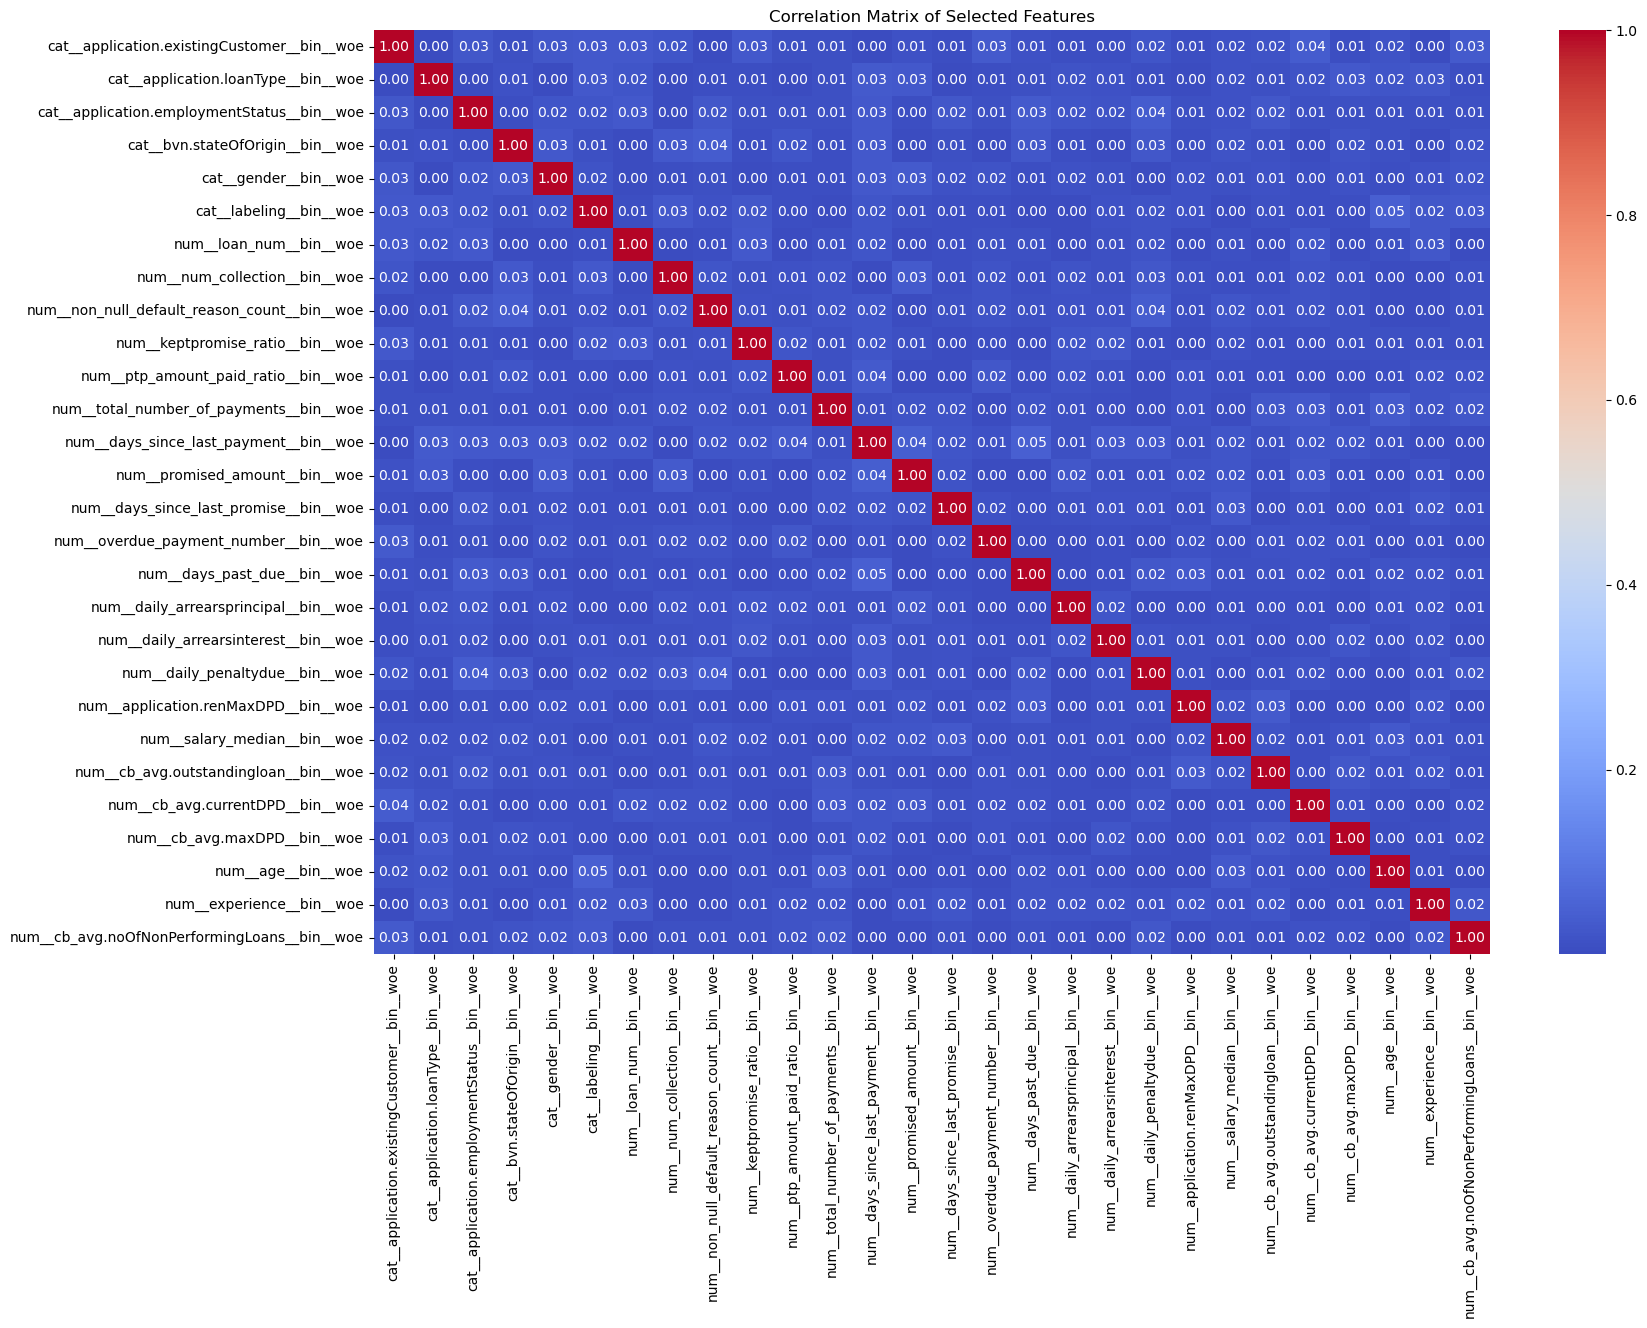

In [31]:
selected_features = clf.features_lst

X_selected = df8[selected_features].copy()

# Compute correlation matrix (absolute to focus on magnitude)
corr_matrix = X_selected.corr().abs()

# Visualize correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Selected Features")
plt.show()

# Model pipeline

## Single pipe

In [32]:
p = {

    "encoding_categorical__tol":0.001,
    "encoding_categorical__n_categories":1,
    
    "binning_cat__max_n_bins":4,
    "binning_cat__min_bin_size":0.15,
    "binning_cat__min_target_diff":0.02,

    "binning_num__max_n_bins":4,
    "binning_num__min_bin_size":0.15,
    "binning_num__min_target_diff":0.02,
    
    # "encoding_pairing__features_pattern":"^cat__.*__bin$",
    # "encoding_pairing__max_cardinality":4,
    # "encoding_pairing__iv_min":0.07,
    
    # "encoding_feature_elimination__correlation_thr":0.8,
    # "encoding_feature_elimination__constant_share_thr":0.97,
    # "encoding_feature_elimination__iv_min":0.01,
    # "encoding_feature_elimination__stab_num_thr": 0.03,
    # "encoding_feature_elimination__stab_cat_thr": 0.8,
    
    "encoding_feature_elimination_2__correlation_thr":0.8,
    "encoding_feature_elimination_2__constant_share_thr":0.97,
    "encoding_feature_elimination_2__iv_min":0.001,
    "encoding_feature_elimination_2__stab_num_thr": 0.03,
    "encoding_feature_elimination_2__stab_cat_thr": 0.8,
    "encoding_feature_elimination_2__cat_features_pattern": r"^$",
    "encoding_feature_elimination_2__num_features_pattern": r"[\w.]+__bin__woe$"
}

In [33]:
pipeline_model = Pipeline(steps=[
    ("features", SimpleFeaturesTransformer(
        num_features_dct,
        cat_features_dct,
        time_elapsed_features_lst,
        flag_features_lst
    )),
    
    ("encoding_categorical", CustomRareCategoriesTransformer()),
    #("encoding_feature_elimination", FeatureEliminationTransformer()), 
    ("binning_cat", BinningCategoriesTransformer_collection()),
    ("binning_num", BinningNumericalTransformer_collection()),
    #("encoding_pairing", PairedFeaturesTransformer()),       
    ("woe_tr", WoeEncoderTransformer_collection()),   
    ("encoding_feature_elimination_2", FeatureEliminationTransformer(
        num_features_pattern = r"[\w.]+__bin__woe$", 
        cat_features_pattern = r"^$")),
    ("model", 
     CustomLogisticRegressionClassifier()),
])

In [34]:
pipeline_model.set_params(**p)

Pipeline(steps=[('features',
                 SimpleFeaturesTransformer(cat_features_missings={'application.employmentSector': '__MISSING__',
                                                                  'application.employmentStatus': '__MISSING__',
                                                                  'application.existingCustomer': '__MISSING__',
                                                                  'application.lastLoanStatus': '__MISSING__',
                                                                  'application.loanType': '__MISSING__',
                                                                  'application.maritalStatus': '__MISSING__',
                                                                  'application.req...
                 BinningNumericalTransformer_collection(min_bin_size=0.15)),
                ('woe_tr', WoeEncoderTransformer_collection()),
                ('encoding_feature_elimination_2',
                 FeatureEliminationTransformer(cat_features_pattern='^$',
                                               constant_share_thr=0.97,
                                               iv_min=0.001,
                                               num_features_pattern='[\\w.]+__bin__woe$')),
                ('model',
                 CustomLogisticRegressionClassifier(features_pattern=re.compile('[\\w\\.]+__bin__woe$')))])

### Train/test split

In [35]:
df[TS_COL] = df['snap_date']    #.fillna(df['app_date'])

# Convert column to datetime
df[TS_COL] = pd.to_datetime(df[TS_COL], errors='coerce')

# Convert filter bounds to datetime
dt_start = datetime.strptime(DT_START, "%Y-%m-%d")
dt_end = datetime.strptime(DT_END, "%Y-%m-%d")

# Filter DataFrame
df = df_filter_by_dts(df, dt_start, dt_end, TS_COL)

# Extract only dates for min and max values
min_date, max_date = df[TS_COL].dt.date.min(), df[TS_COL].dt.date.max()
print(min_date, max_date)

2025-01-01 2025-03-31


In [36]:
df = df_filter_by_dts(df, dt_start, dt_end, TS_COL)
test_size = int(len(df) * 0.2)
test_size

df["sample"] = "train"
df.iloc[-test_size:, df.columns.get_loc("sample")] = "test"
test_size

472

In [37]:
df[df['sample'] == 'train'][TS_COL].max()

Timestamp('2025-03-31 00:00:00')

## Fit

In [38]:
pipeline_model.fit(
    X=df[df['sample'] == 'train'].drop(TARGET, axis=1),
    y=df[df['sample'] == 'train'][TARGET],
)

2025-12-17 23:28:53 - INFO - Simple features - Successfully finished.
2025-12-17 23:28:53 - INFO - Rare categories encoder - fit done
2025-12-17 23:28:53 - INFO - Rare categories encoder - transform done.
2025-12-17 23:28:53 - INFO - Cat. binning - fit done.
2025-12-17 23:28:53 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:30:05 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 3.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.09866447001695633, 0.18452084064483643, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12676559388637543, 0.44749487936496735, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8917.52783203125, 11771.85400390625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4826.5830078125, 6980.80419921875, 18124.44140625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins

2025-12-17 23:30:05 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1219.6722412109375, 1900.712158203125, 3698.6998291015625, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 35.5, 81.5, 126.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 18911.4501953125, 23272.0546875, 29559.384765625, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5258.410430706626, 26020.0224609375, 34673.404296875, 50152.314453125, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 9323.15478515625, 22591.798828125, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 36.5, 90.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 31.5, 62.5, 144.5, inf]
Feature: num__age, Bins: [18.0, 26.5, 33.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 7.5, 17.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [0.0, 2.5, 12.5, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [0.0, 3.5, 10.5, inf]


2025-12-17 23:30:05 - INFO - WOE cat encoder - fit done.
2025-12-17 23:30:05 - INFO - WOE cat encoder - transform done.
2025-12-17 23:30:05 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:30:05 - INFO - Feature elimination - after dups dropping:         41
2025-12-17 23:30:05 - INFO - Feature elimination - after constants dropping:     40
2025-12-17 23:30:05 - INFO - Feature elimination - after decorrelation:     40
2025-12-17 23:30:06 - INFO - Feature elimination - after num non-stab dropping:     36
2025-12-17 23:30:06 - INFO - Feature elimination - fit done.
2025-12-17 23:30:06 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:30:06 - INFO - Feature elimination - transform done.
2025-12-17 23:30:06 - INFO - Modeling: LogisticRegression with feature selection.
2025-12-17 23:30:06 - INFO - ==========================
2025-12-17 23:30:06 - INFO - Features cnt: 35
2025-12-17 23:30:06 - INFO - Dropped:      num__total_number_of_promis

Pipeline(steps=[('features',
                 SimpleFeaturesTransformer(cat_features_missings={'application.employmentSector': '__MISSING__',
                                                                  'application.employmentStatus': '__MISSING__',
                                                                  'application.existingCustomer': '__MISSING__',
                                                                  'application.lastLoanStatus': '__MISSING__',
                                                                  'application.loanType': '__MISSING__',
                                                                  'application.maritalStatus': '__MISSING__',
                                                                  'application.req...
                                                                  'num__days_past_due__bin__woe',
                                                                  'num__daily_arrearsprincipal__bin__woe',
                                                                  'num__daily_arrearsinterest__bin__woe',
                                                                  'num__daily_penaltydue__bin__woe',
                                                                  'num__salary_median__bin__woe',
                                                                  'num__cb_avg.outstandingloan__bin__woe',
                                                                  'num__cb_avg.totalMonthlyInstallments__bin__woe',
                                                                  'num__cb_avg.currentDPD__bin__woe',
                                                                  'num__age__bin__woe'],
                                                    features_pattern=re.compile('[\\w\\.]+__bin__woe$')))])

In [39]:
# Predict scores on all data set

df['y_pred'] = pipeline_model.predict(df.drop(TARGET, axis=1))

2025-12-17 23:30:06 - INFO - Simple features - Successfully finished.
2025-12-17 23:30:06 - INFO - Rare categories encoder - transform done.
2025-12-17 23:30:06 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_num, Bins: [0.0, 3.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.09866447001695633, 0.18452084064483643, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12676559388637543, 0.44749487936496735, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8917.52783203125, 11771.85400390625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4826.5830078125, 6980.80419921875, 18124.44140625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins

2025-12-17 23:30:07 - INFO - Num. binning - tranfsorm done.


Feature: num__days_past_due, Bins: [1.0, 5.5, 11.5, 25.5, inf]
Feature: num__loan_balance, Bins: [-1.0, inf]
Feature: num__daily_arrearsprincipal, Bins: [235.29119951632651, 2845.95947265625, 7898.671142578125, 12774.08642578125, inf]
Feature: num__daily_arrearsinterest, Bins: [92.41374985477323, 1202.758056640625, 2545.6839599609375, 6896.3564453125, inf]
Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1219.6722412109375, 1900.712158203125, 3698.6998291015625, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 35.5, 81.5, 126.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 18911.4501953125, 23272.0546875, 29559.384765625, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5258.410430706626, 26020.0224609375, 34673.404296875, 50152.314453125, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 9323.15478515625, 22591.798828125, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 36.5, 90.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1

/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) num__promised_amount__bin, num__cb_avg.outstandingloan__bin.
  warnings.warn(
2025-12-17 23:30:07 - INFO - WOE cat encoder - transform done.
2025-12-17 23:30:07 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:30:07 - INFO - Feature elimination - transform done.
2025-12-17 23:30:07 - INFO - Modeling: LogisticRegression - prediction done.


In [40]:
roc_auc_score(
    df[df['sample'] == 'test'][TARGET],
    df[df['sample'] == 'test']['y_pred']
)

0.6748358074673865

In [41]:
roc_auc_score(
    df[df['sample'] == 'train'][TARGET],
    df[df['sample'] == 'train']['y_pred']
)

0.7641376272161686

<AxesSubplot:>

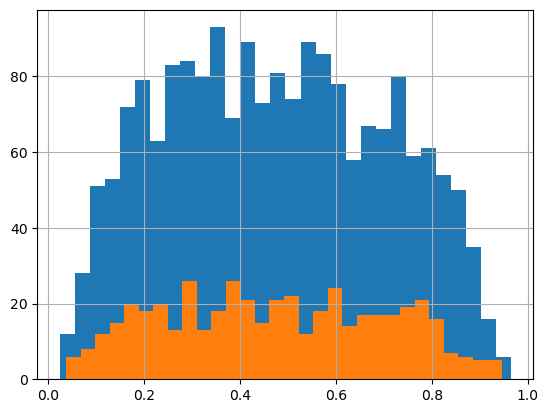

In [42]:
df[df['sample'] == 'train']['y_pred'].hist(bins=30)
df[df['sample'] == 'test']['y_pred'].hist(bins=30)

In [43]:
pipeline_model.steps[-1][1].features_lst

['cat__customer.addressLGA__bin__woe',
 'cat__application.existingCustomer__bin__woe',
 'cat__application.employmentStatus__bin__woe',
 'cat__gender__bin__woe',
 'cat__labeling__bin__woe',
 'num__num_collection__bin__woe',
 'num__non_null_default_reason_count__bin__woe',
 'num__keptpromise_ratio__bin__woe',
 'num__ptp_amount_paid_ratio__bin__woe',
 'num__total_payment__bin__woe',
 'num__total_number_of_payments__bin__woe',
 'num__days_since_last_payment__bin__woe',
 'num__days_since_last_promise__bin__woe',
 'num__overdue_payment_number__bin__woe',
 'num__days_past_due__bin__woe',
 'num__daily_arrearsprincipal__bin__woe',
 'num__daily_arrearsinterest__bin__woe',
 'num__daily_penaltydue__bin__woe',
 'num__salary_median__bin__woe',
 'num__cb_avg.outstandingloan__bin__woe',
 'num__cb_avg.totalMonthlyInstallments__bin__woe',
 'num__cb_avg.currentDPD__bin__woe',
 'num__age__bin__woe']

In [44]:
len(pipeline_model.steps[-1][1].features_lst)

23

In [45]:
model = pipeline_model.steps[-1][1].estimator

In [46]:
# Extract coefficients from the underlying statsmodels Logit model
coefs = pipeline_model.steps[-1][1].estimator.params

# Optionally, include p-values as well if you want to mimic a feature importance DataFrame
p_values = pipeline_model.steps[-1][1].estimator.pvalues

# Create a DataFrame
feature_importances_df = pd.DataFrame({
    'coef': coefs,
    'p_value': p_values
})

# Sort by the absolute value of the coefficient to get the most influential features at the top
feature_importances_df = feature_importances_df.reindex(
    feature_importances_df['coef'].abs().sort_values(ascending=False).index
).head(50)

print(feature_importances_df)

                                                    coef       p_value
num__cb_avg.totalMonthlyInstallments__bin__woe  1.557952  1.096786e-03
num__total_payment__bin__woe                    1.432665  3.216080e-02
num__overdue_payment_number__bin__woe           1.392676  3.088848e-04
num__ptp_amount_paid_ratio__bin__woe            1.380663  8.891336e-03
num__salary_median__bin__woe                    1.331648  1.717241e-02
cat__gender__bin__woe                           1.309628  1.041123e-03
cat__labeling__bin__woe                         1.261507  3.076809e-03
num__cb_avg.outstandingloan__bin__woe           1.234318  3.566001e-02
num__non_null_default_reason_count__bin__woe    1.224999  2.886072e-04
num__days_since_last_promise__bin__woe          1.207158  6.141936e-03
num__keptpromise_ratio__bin__woe                1.180339  3.429689e-04
num__cb_avg.currentDPD__bin__woe                1.144620  8.477922e-02
num__total_number_of_payments__bin__woe         1.142449  1.465994e-05
num__a

## Model unload (PICKLE)

In [47]:
pipeline_model

Pipeline(steps=[('features',
                 SimpleFeaturesTransformer(cat_features_missings={'application.employmentSector': '__MISSING__',
                                                                  'application.employmentStatus': '__MISSING__',
                                                                  'application.existingCustomer': '__MISSING__',
                                                                  'application.lastLoanStatus': '__MISSING__',
                                                                  'application.loanType': '__MISSING__',
                                                                  'application.maritalStatus': '__MISSING__',
                                                                  'application.req...
                                                                  'num__days_past_due__bin__woe',
                                                                  'num__daily_arrearsprincipal__bin__woe',
                                                                  'num__daily_arrearsinterest__bin__woe',
                                                                  'num__daily_penaltydue__bin__woe',
                                                                  'num__salary_median__bin__woe',
                                                                  'num__cb_avg.outstandingloan__bin__woe',
                                                                  'num__cb_avg.totalMonthlyInstallments__bin__woe',
                                                                  'num__cb_avg.currentDPD__bin__woe',
                                                                  'num__age__bin__woe'],
                                                    features_pattern=re.compile('[\\w\\.]+__bin__woe$')))])

In [48]:
joblib.dump(pipeline_model, 'cs_internal_SEL_BETA_5_30.joblib')

['cs_internal_SEL_BETA_5_30.joblib']

In [49]:
from datetime import datetime

datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2025-12-17 23:30:07'

## Import helpers 

In [50]:
# for import custom libraries

import sys
sys.path.append('../libs')

In [51]:
# custom library with our functions 

from general_lib import (parse_json_field, 
                        df_filter_by_dts, 
                        yymm, 
                        yyww, 
                        add_yy_mm, 
                        add_ww_mm_date)
from plotter_lib import (plot_fpd_by_time, 
                        plot_roc, 
                        plot_mean_target_in_time, 
                        plot_correlation_with_target,
                        plot_roc_fixed)
from optbin_lib import (get_values_map, 
                        get_optbin_info_cat, 
                        get_optbin_info_num)
from metrics_lib import (calculate_information_values, 
                        get_num_feature_stability_index, 
                        get_cat_feature_stability_index)

# Model metrics 

## Features drift

In [52]:
pipeline_data = Pipeline(steps=pipeline_model.steps[:-1])

# pipeline_data.fit(
#     X=df[df['sample'] == 'train'].drop(TARGET, axis=1),
#     y=df[df['sample'] == 'train'][TARGET]
# )

In [53]:
df_features_drift = pipeline_data.transform(
    X=df[df['sample'] == 'train']
)

2025-12-17 23:30:07 - INFO - Simple features - Successfully finished.
2025-12-17 23:30:07 - INFO - Rare categories encoder - transform done.
2025-12-17 23:30:07 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_num, Bins: [0.0, 3.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.09866447001695633, 0.18452084064483643, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12676559388637543, 0.44749487936496735, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8917.52783203125, 11771.85400390625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4826.5830078125, 6980.80419921875, 18124.44140625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins

2025-12-17 23:30:08 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_arrearsinterest, Bins: [92.41374985477323, 1202.758056640625, 2545.6839599609375, 6896.3564453125, inf]
Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1219.6722412109375, 1900.712158203125, 3698.6998291015625, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 35.5, 81.5, 126.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 18911.4501953125, 23272.0546875, 29559.384765625, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5258.410430706626, 26020.0224609375, 34673.404296875, 50152.314453125, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 9323.15478515625, 22591.798828125, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 36.5, 90.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 31.5, 62.5, 144.5, inf]
Feature: num__age, Bins: [18.0, 26.5, 33.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 7.5, 17.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__cb_avg.noOfNonPerformingL

2025-12-17 23:30:08 - INFO - WOE cat encoder - transform done.
2025-12-17 23:30:08 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:30:08 - INFO - Feature elimination - transform done.


In [54]:
df_features_drift[TARGET] = df[df['sample'] == 'train'][TARGET].values
df_features_drift['dt_month'] = df[df['sample'] == 'train']['dt_month'].values
df_features_drift['dt_week'] = df[df['sample'] == 'train']['dt_week'].values

In [55]:
df_features_drift['dt_month'].min(), df_features_drift['dt_month'].max()

ts_min, ts_max = (
    df[df['sample'] == 'train'][TS_COL].min(),
    df[df['sample'] == 'train'][TS_COL].max()
)
ts_min, ts_max

(Timestamp('2025-01-01 00:00:00'), Timestamp('2025-03-31 00:00:00'))

In [56]:
pipeline_model.steps[-1][1].features_lst

['cat__customer.addressLGA__bin__woe',
 'cat__application.existingCustomer__bin__woe',
 'cat__application.employmentStatus__bin__woe',
 'cat__gender__bin__woe',
 'cat__labeling__bin__woe',
 'num__num_collection__bin__woe',
 'num__non_null_default_reason_count__bin__woe',
 'num__keptpromise_ratio__bin__woe',
 'num__ptp_amount_paid_ratio__bin__woe',
 'num__total_payment__bin__woe',
 'num__total_number_of_payments__bin__woe',
 'num__days_since_last_payment__bin__woe',
 'num__days_since_last_promise__bin__woe',
 'num__overdue_payment_number__bin__woe',
 'num__days_past_due__bin__woe',
 'num__daily_arrearsprincipal__bin__woe',
 'num__daily_arrearsinterest__bin__woe',
 'num__daily_penaltydue__bin__woe',
 'num__salary_median__bin__woe',
 'num__cb_avg.outstandingloan__bin__woe',
 'num__cb_avg.totalMonthlyInstallments__bin__woe',
 'num__cb_avg.currentDPD__bin__woe',
 'num__age__bin__woe']

In [57]:
f_num_list = [f for f in pipeline_model.steps[-1][1].features_lst if f.endswith('__bin__woe')]

cat__customer.addressLGA__bin__woe: 0.06654339156428613
cat__application.existingCustomer__bin__woe: 0.09538163575251832
cat__application.employmentStatus__bin__woe: 0.18752958630449523
cat__gender__bin__woe         : 0.06546012390957402
cat__labeling__bin__woe       : 0.07735010529314032
num__num_collection__bin__woe : 0.07075818874537863
num__non_null_default_reason_count__bin__woe: 0.07669537223828156
num__keptpromise_ratio__bin__woe: 0.07824418923727383
num__ptp_amount_paid_ratio__bin__woe: 0.049104623704123725
num__total_payment__bin__woe  : 0.04023312552270859
num__total_number_of_payments__bin__woe: 0.09968390141411027
num__days_since_last_payment__bin__woe: 0.29905278340971075
num__days_since_last_promise__bin__woe: 0.05848635543494937
num__overdue_payment_number__bin__woe: 0.06716465303141596
num__days_past_due__bin__woe  : 0.07540223527999466
num__daily_arrearsprincipal__bin__woe: 0.059109674322282264
num__daily_arrearsinterest__bin__woe: 0.06082838817687522
num__daily_penalt

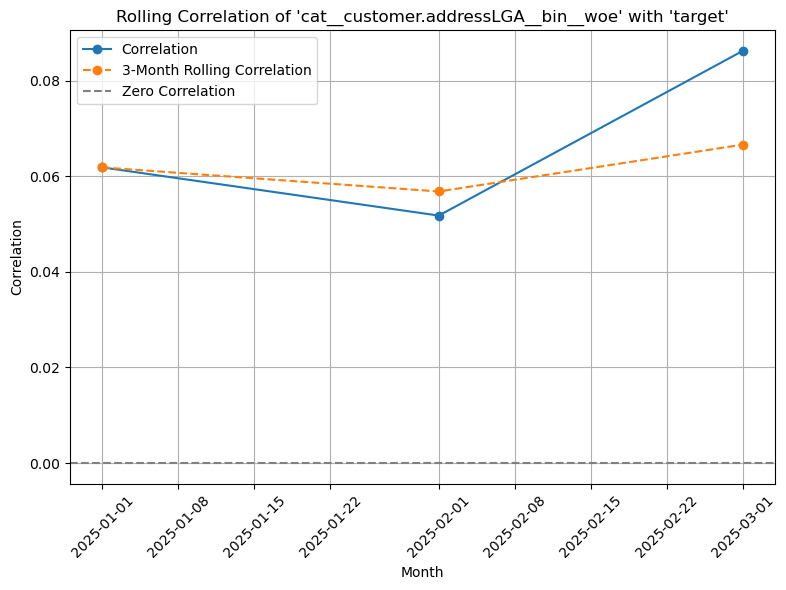

cat__application.existingCustomer__bin__woe
0.09335425155117229


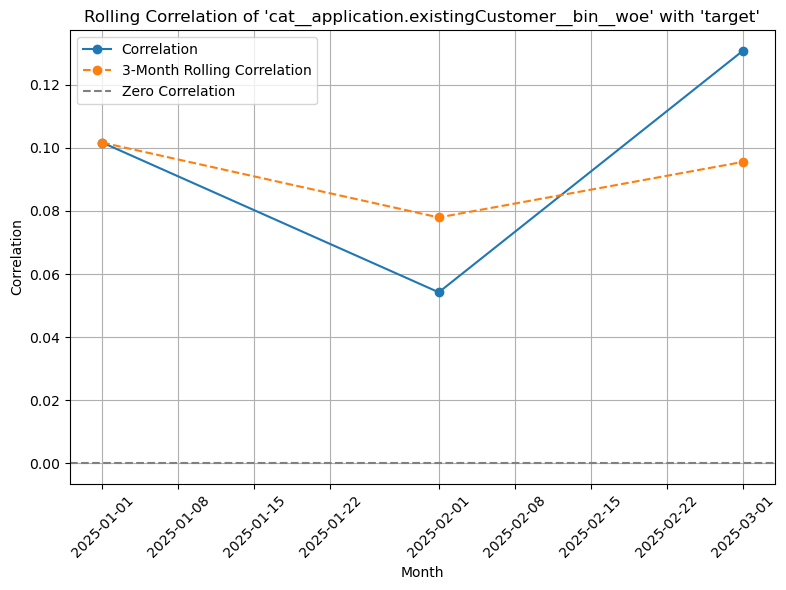

cat__application.employmentStatus__bin__woe
0.09335425155117229


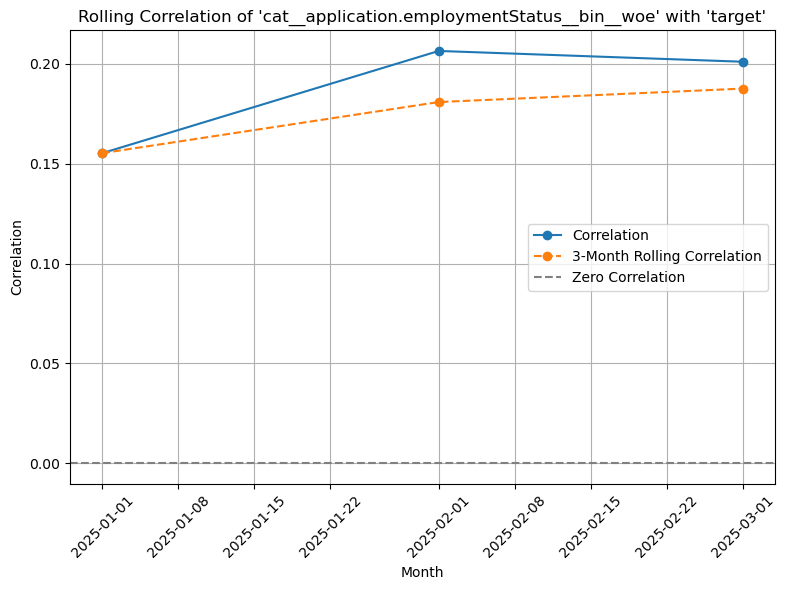

cat__gender__bin__woe
0.09335425155117229


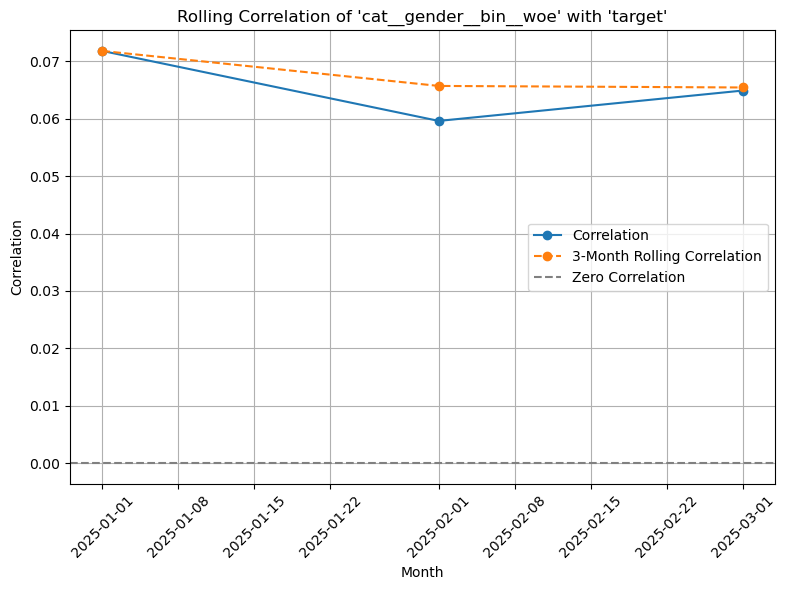

cat__labeling__bin__woe
0.09335425155117229


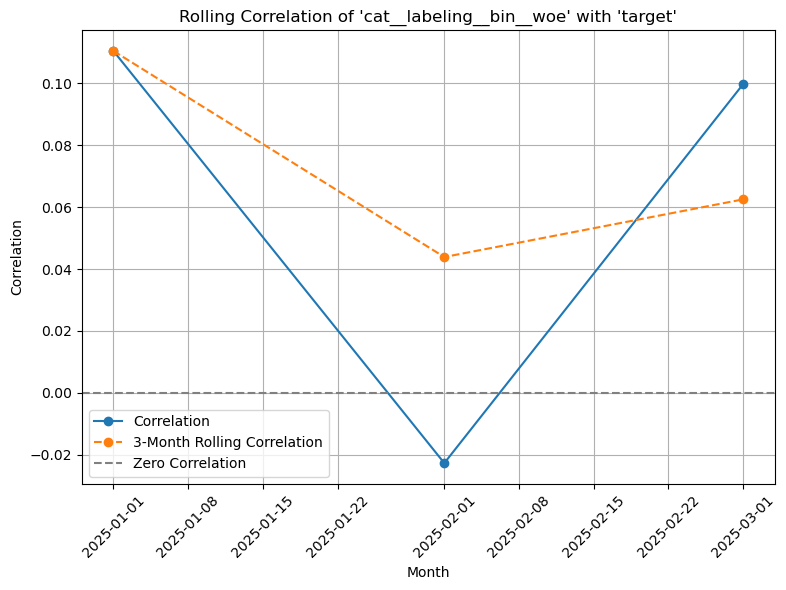

num__num_collection__bin__woe
0.09335425155117229


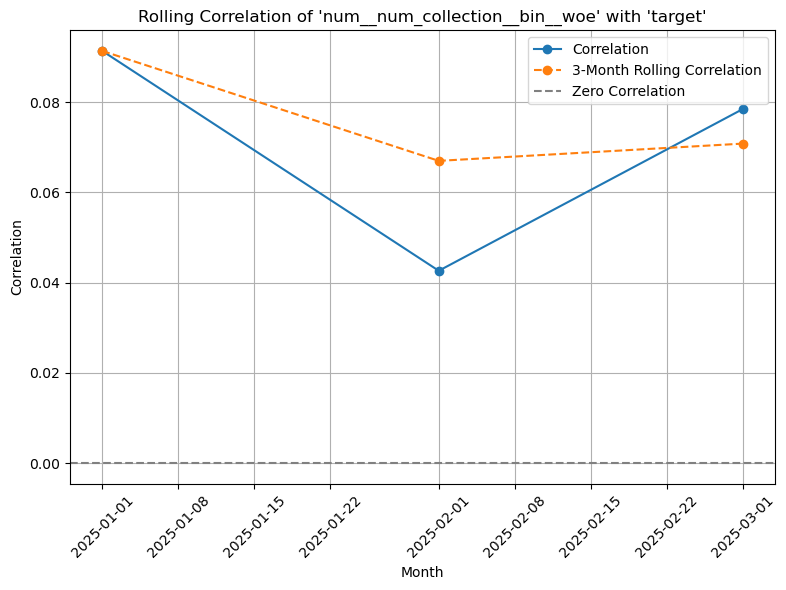

num__non_null_default_reason_count__bin__woe
0.09335425155117229


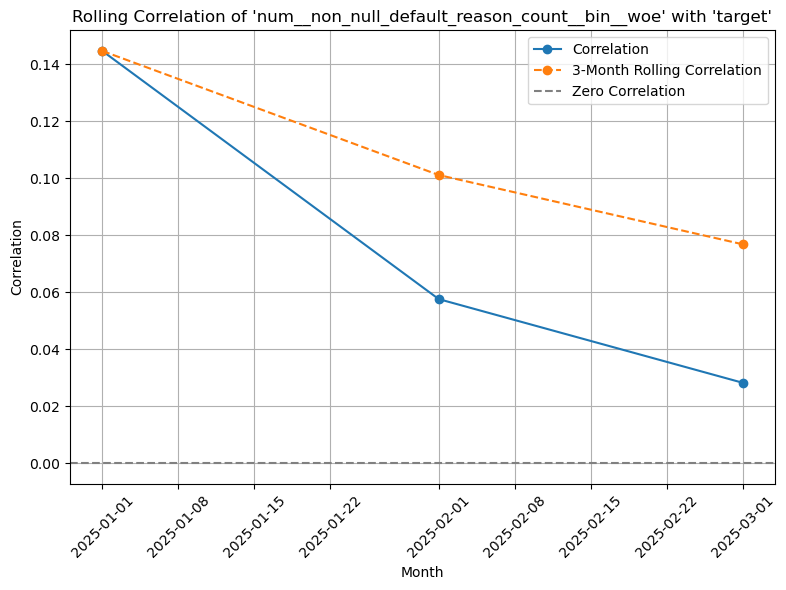

num__keptpromise_ratio__bin__woe
0.09335425155117229


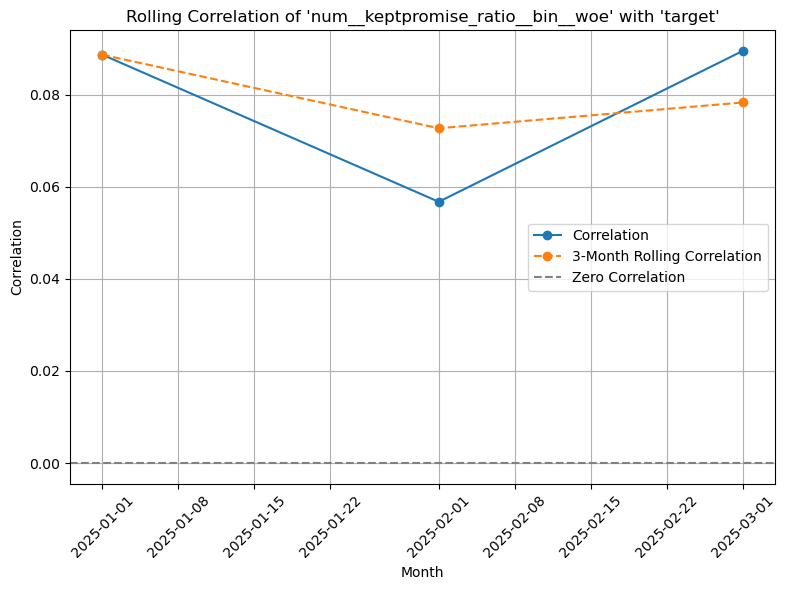

num__ptp_amount_paid_ratio__bin__woe
0.09335425155117229


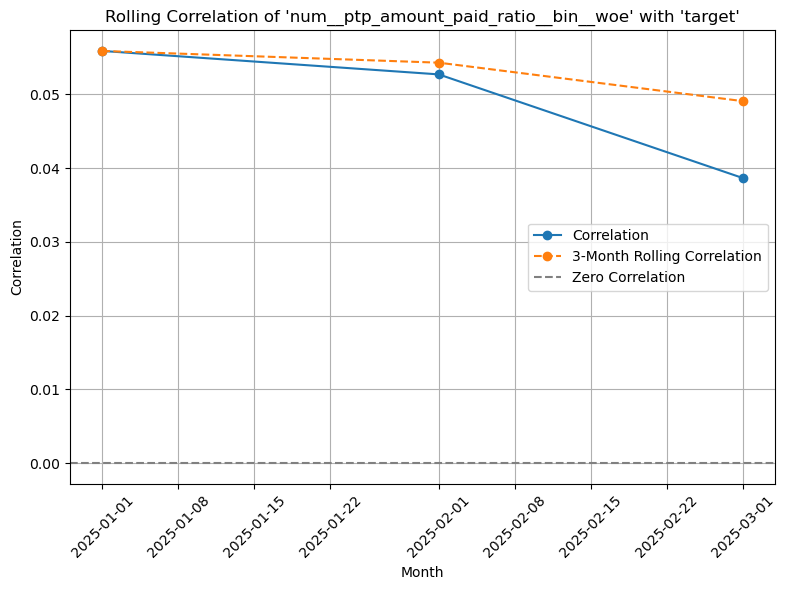

num__total_payment__bin__woe
0.09335425155117229


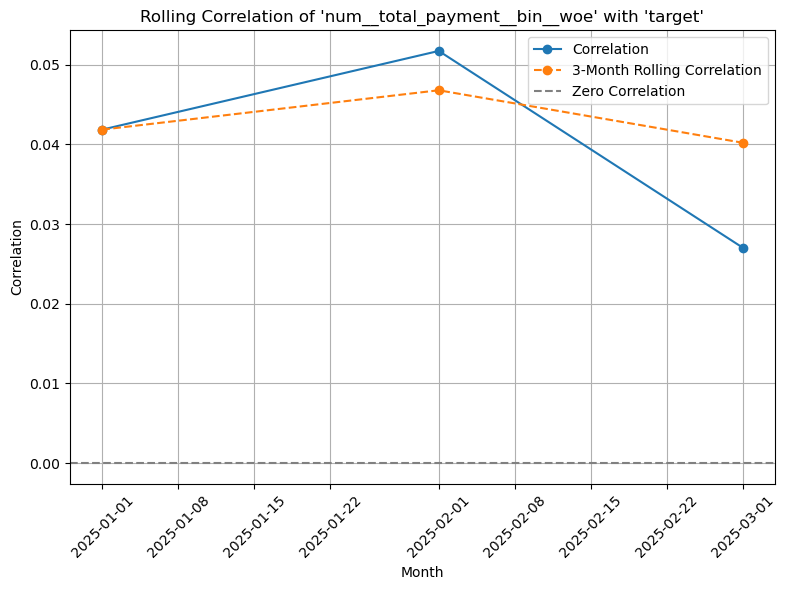

num__total_number_of_payments__bin__woe
0.09335425155117229


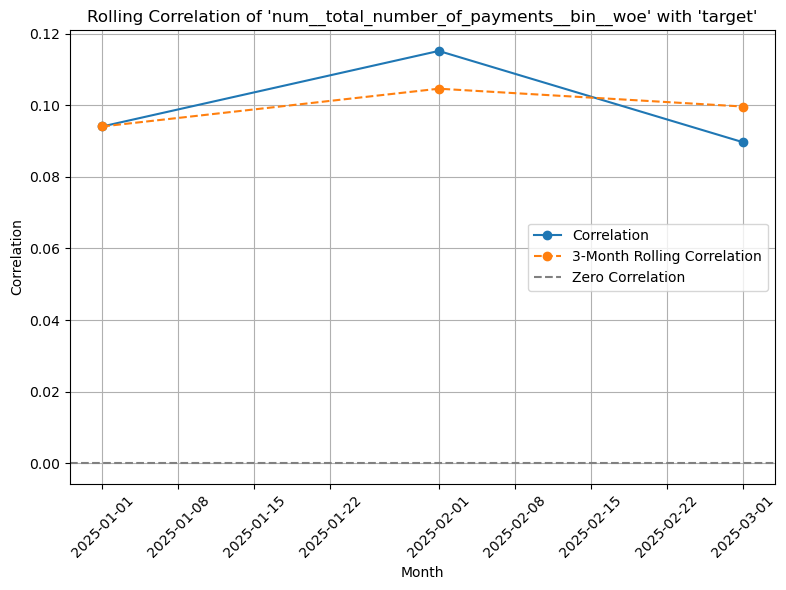

num__days_since_last_payment__bin__woe
0.09335425155117229


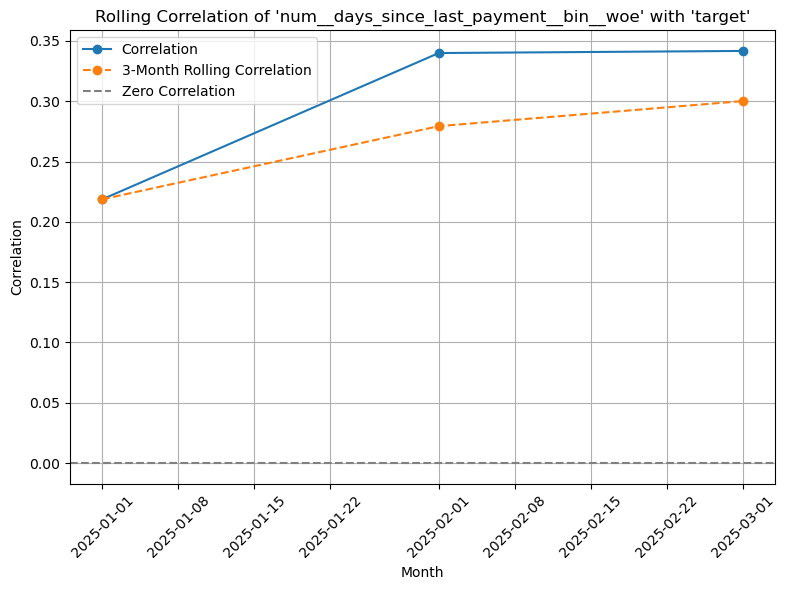

num__days_since_last_promise__bin__woe
0.09335425155117229


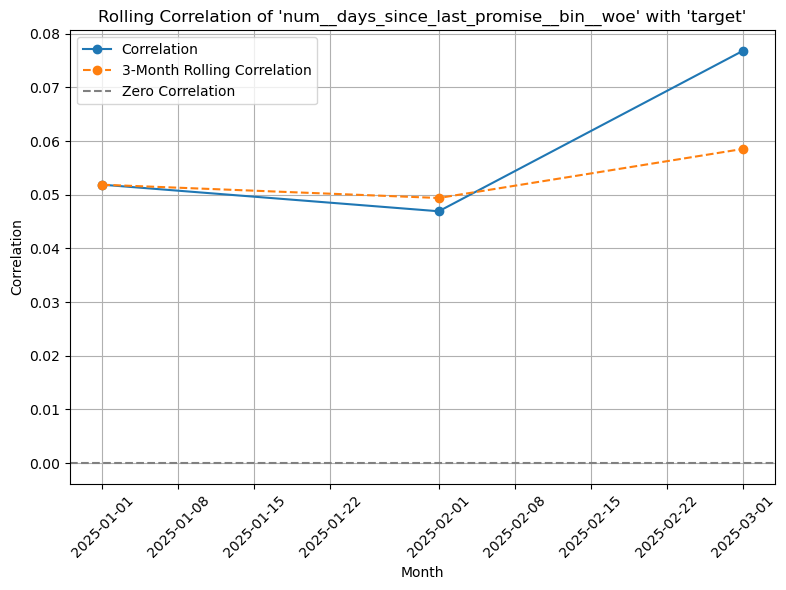

num__overdue_payment_number__bin__woe
0.09335425155117229


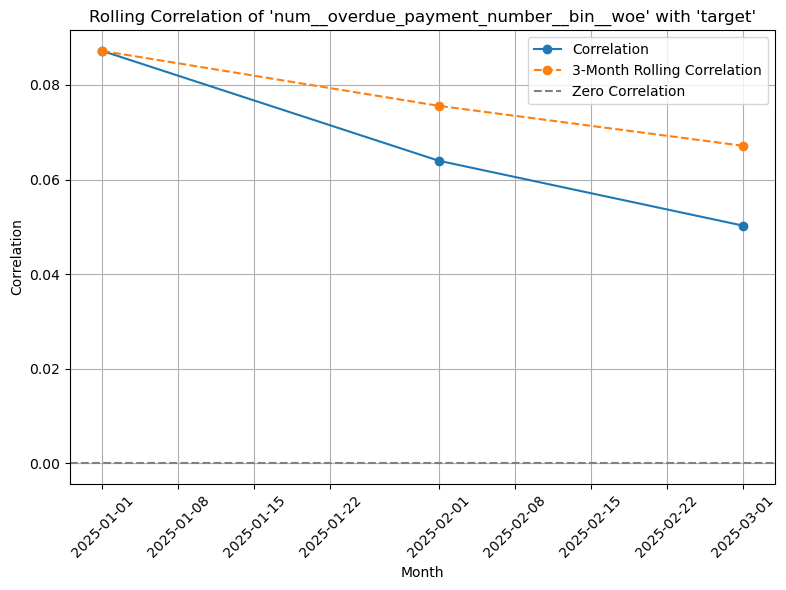

num__days_past_due__bin__woe
0.09335425155117229


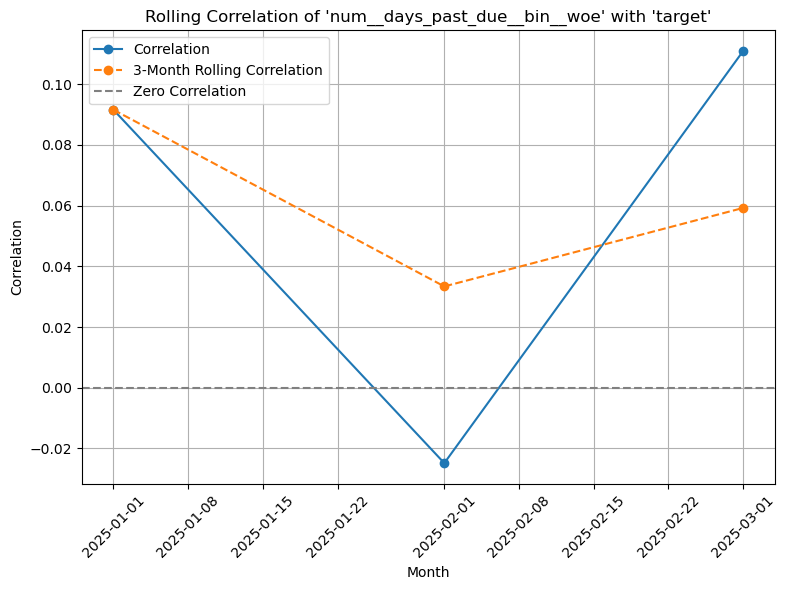

num__daily_arrearsprincipal__bin__woe
0.09335425155117229


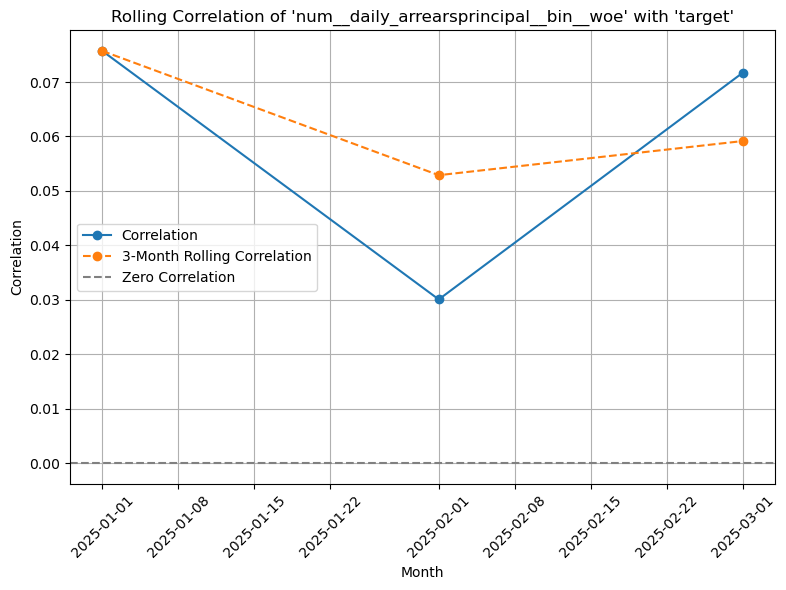

num__daily_arrearsinterest__bin__woe
0.09335425155117229


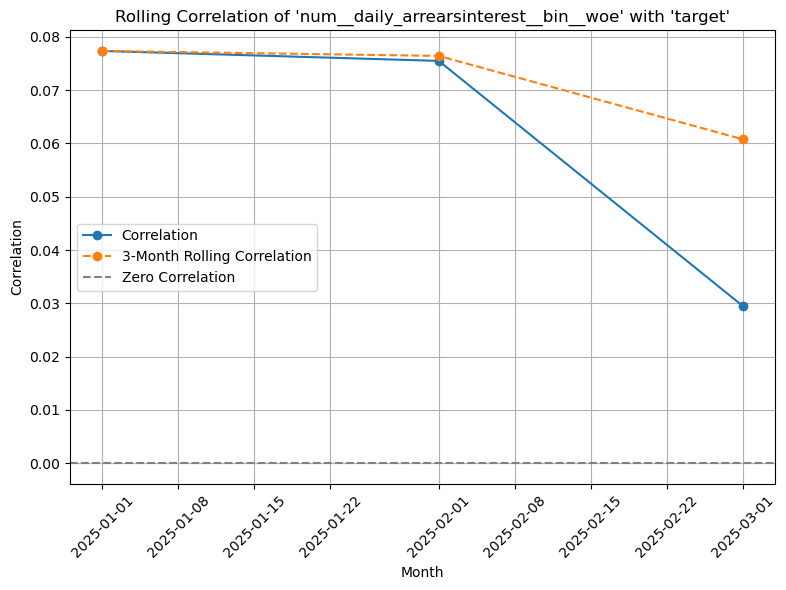

num__daily_penaltydue__bin__woe
0.09335425155117229


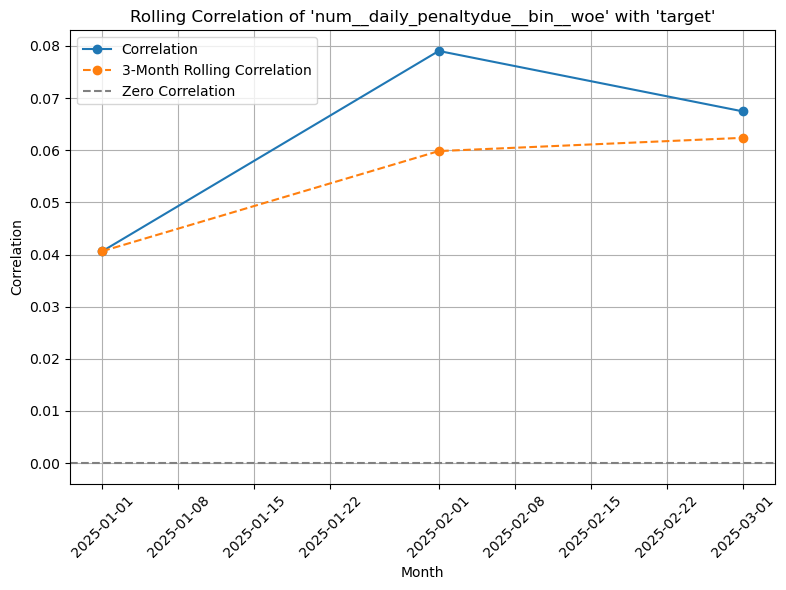

num__salary_median__bin__woe
0.09335425155117229


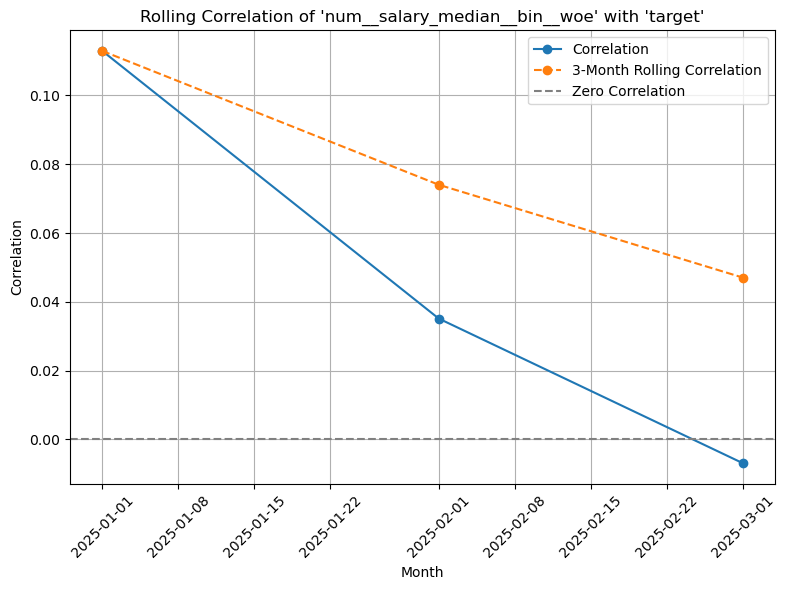

num__cb_avg.outstandingloan__bin__woe
0.09335425155117229


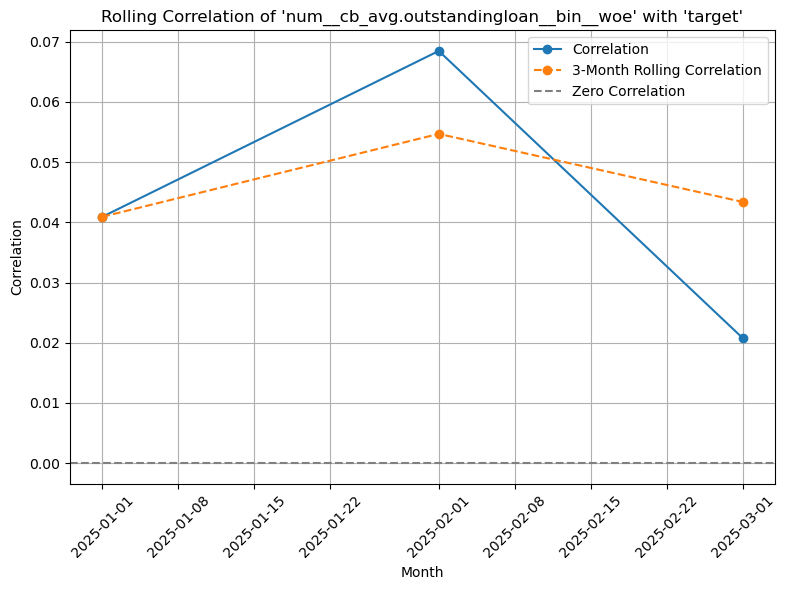

num__cb_avg.totalMonthlyInstallments__bin__woe
0.09335425155117229


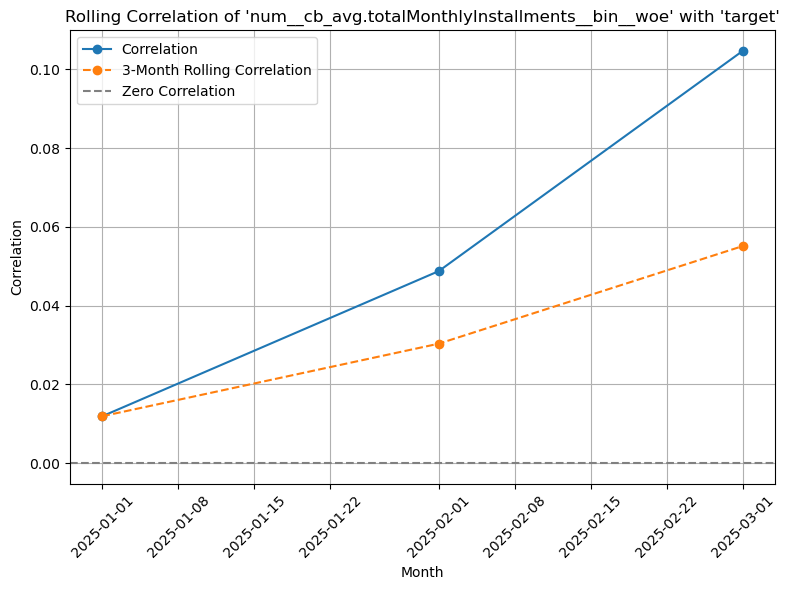

num__cb_avg.currentDPD__bin__woe
0.09335425155117229


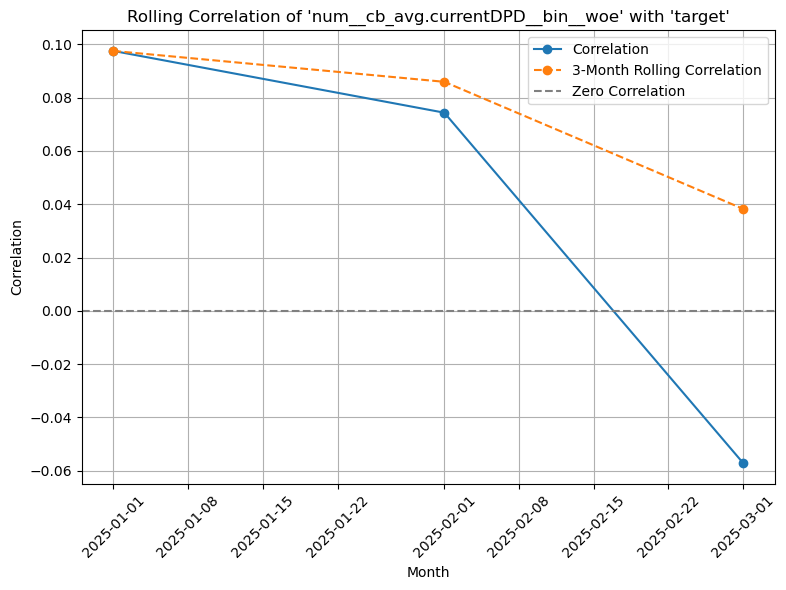

num__age__bin__woe
0.09335425155117229


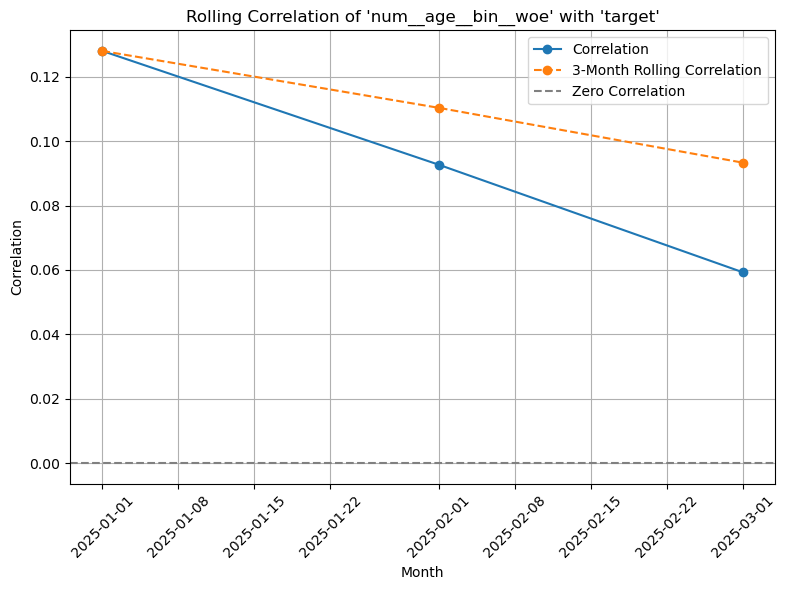

In [58]:
for f in f_num_list:
    
    instab_index = get_num_feature_stability_index(
        df_features_drift, 
        'dt_month', 
        f, 
        TARGET
    )
    print(f"{f:30}: {instab_index:5}")

for f in f_num_list:
    print(f)
    print(instab_index)
    plot_correlation_with_target(
        df_features_drift, 
        'dt_month', 
        f, 
        TARGET
    )

In [59]:
columns = pipeline_model.steps[-1][1].features_lst
print(columns)
prefinal_columns = [col.replace('cat__', '')
                     .replace('num__time_elapsed__', '')
                     .replace('num__', '')
                     .replace('__bin__woe', '')
                 for col in columns]
prefinal_columns = [col for col in prefinal_columns if col != 'input.salaryservice.monthlyElectricitySpending6' and col != 'input.salaryservice.agentSalaryDate4' and col != 'input.salaryservice.minBalanceWk' and col != 'input.salaryservice.closingBalance' and col != 'input.salaryservice.dayDiffDebit']

['cat__customer.addressLGA__bin__woe', 'cat__application.existingCustomer__bin__woe', 'cat__application.employmentStatus__bin__woe', 'cat__gender__bin__woe', 'cat__labeling__bin__woe', 'num__num_collection__bin__woe', 'num__non_null_default_reason_count__bin__woe', 'num__keptpromise_ratio__bin__woe', 'num__ptp_amount_paid_ratio__bin__woe', 'num__total_payment__bin__woe', 'num__total_number_of_payments__bin__woe', 'num__days_since_last_payment__bin__woe', 'num__days_since_last_promise__bin__woe', 'num__overdue_payment_number__bin__woe', 'num__days_past_due__bin__woe', 'num__daily_arrearsprincipal__bin__woe', 'num__daily_arrearsinterest__bin__woe', 'num__daily_penaltydue__bin__woe', 'num__salary_median__bin__woe', 'num__cb_avg.outstandingloan__bin__woe', 'num__cb_avg.totalMonthlyInstallments__bin__woe', 'num__cb_avg.currentDPD__bin__woe', 'num__age__bin__woe']


In [60]:
prefinal_columns

['customer.addressLGA',
 'application.existingCustomer',
 'application.employmentStatus',
 'gender',
 'labeling',
 'num_collection',
 'non_null_default_reason_count',
 'keptpromise_ratio',
 'ptp_amount_paid_ratio',
 'total_payment',
 'total_number_of_payments',
 'days_since_last_payment',
 'days_since_last_promise',
 'overdue_payment_number',
 'days_past_due',
 'daily_arrearsprincipal',
 'daily_arrearsinterest',
 'daily_penaltydue',
 'salary_median',
 'cb_avg.outstandingloan',
 'cb_avg.totalMonthlyInstallments',
 'cb_avg.currentDPD',
 'age']

## ROC-AUC

In [61]:
roc_auc_score(
    df[df['sample'] == 'test'][TARGET],
    df[df['sample'] == 'test']['y_pred']
)

0.6748358074673865

In [62]:
roc_auc_score(
    df[df['sample'] == 'train'][TARGET],
    df[df['sample'] == 'train']['y_pred']
)

0.7641376272161686

<AxesSubplot:>

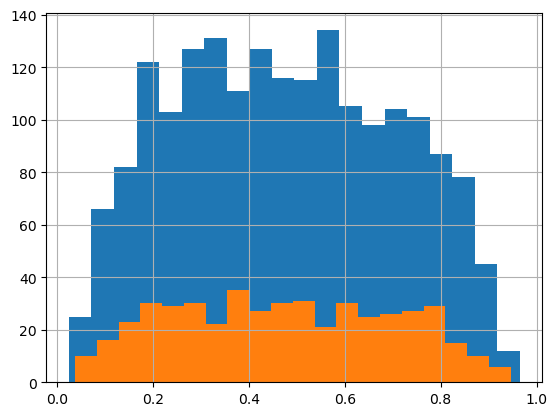

In [63]:
df[df['sample'] == 'train']['y_pred'].hist(bins=20)
df[df['sample'] == 'test']['y_pred'].hist(bins=20)

In [64]:
def plot_roc(model, X_train=None, y_train=None, X_test=None, y_test=None, save_plot=False):

    # model_name = str(model.__class__).split('.')[-1][:-2]
    
    plt.figure()
    
    if ((X_train is not None) and (y_train is not None)):
        y_pred_train = model.predict(X_train)
        
        roc_auc_train = roc_auc_score(y_train, y_pred_train)
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
        
        plt.plot(fpr_train, tpr_train, label='train (%0.3f)' % roc_auc_train)  
        
    if ((X_test is not None) and (y_test is not None)):
        y_pred_test = model.predict(X_test)
        
        roc_auc_test = roc_auc_score(y_test, y_pred_test)
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
        
        plt.plot(fpr_test, tpr_test, label='test (%0.3f)' % roc_auc_test) 

    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC AUC \n \n N features: {len(model.steps[-1][1].features_lst)}')
    plt.legend(loc="lower right")
    plt.grid()

    plt.show()

2025-12-17 23:30:14 - INFO - Simple features - Successfully finished.
2025-12-17 23:30:14 - INFO - Rare categories encoder - transform done.
2025-12-17 23:30:14 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_num, Bins: [0.0, 3.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.09866447001695633, 0.18452084064483643, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12676559388637543, 0.44749487936496735, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8917.52783203125, 11771.85400390625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4826.5830078125, 6980.80419921875, 18124.44140625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins

2025-12-17 23:30:14 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1219.6722412109375, 1900.712158203125, 3698.6998291015625, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 35.5, 81.5, 126.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 18911.4501953125, 23272.0546875, 29559.384765625, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5258.410430706626, 26020.0224609375, 34673.404296875, 50152.314453125, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 9323.15478515625, 22591.798828125, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 36.5, 90.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 31.5, 62.5, 144.5, inf]
Feature: num__age, Bins: [18.0, 26.5, 33.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 7.5, 17.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [0.0, 2.5, 12.5, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [0.0, 3.5, 10.5, inf]


2025-12-17 23:30:14 - INFO - WOE cat encoder - transform done.
2025-12-17 23:30:14 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:30:14 - INFO - Feature elimination - transform done.
2025-12-17 23:30:14 - INFO - Modeling: LogisticRegression - prediction done.
2025-12-17 23:30:14 - INFO - Simple features - Successfully finished.
2025-12-17 23:30:14 - INFO - Rare categories encoder - transform done.
2025-12-17 23:30:14 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:30:15 - INFO - Num. binning - tranfsorm done.
/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) num__promised_amount__bin, num__cb_avg.outstandingloan__bin.
  warnings.warn(
2025-12-17 23:30:15 - INFO - WOE cat encoder - transform done.


Feature: num__loan_num, Bins: [0.0, 3.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.09866447001695633, 0.18452084064483643, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12676559388637543, 0.44749487936496735, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8917.52783203125, 11771.85400390625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4826.5830078125, 6980.80419921875, 18124.44140625, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins

2025-12-17 23:30:15 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:30:15 - INFO - Feature elimination - transform done.
2025-12-17 23:30:15 - INFO - Modeling: LogisticRegression - prediction done.


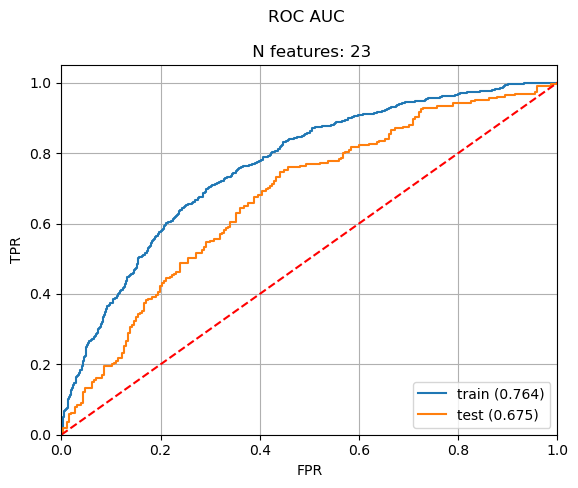

In [65]:
plot_roc(pipeline_model, 
         
    # df_oot.drop(TARGET, axis=1), 
    # df_oot[TARGET], 

    df[df['sample'] == 'train'].drop(TARGET, axis=1), 
    df[df['sample'] == 'train'][TARGET],

    df[df['sample'] == 'test'].drop(TARGET, axis=1), 
    df[df['sample'] == 'test'][TARGET],
)

## Cross validation

In [66]:
def cross_val_predict(estimator, X, y, cv=5, early_stopping_rounds=8):
    # Initialize predictions array
    n_samples = len(X)
    #predictions = np.zeros((n_samples, 2))  # Assuming binary classification
    predictions = np.zeros(n_samples)       #!!!!!!My changing

    # Perform cross-validation
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    for train_index, test_index in kf.split(X, y):
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        try:
            # Fit estimator on training data with early stopping
            estimator.fit(
                X_train,
                y_train,
                model__early_stopping_rounds=early_stopping_rounds,  # Pass early stopping rounds
            )

            # Predict on test data
            y_pred = estimator.predict(X_test)
            # Update predictions array
            predictions[test_index] = y_pred
            
        except Exception as e:
            logger.error(f"Error during fitting or predicting: {e}")
            
    return predictions
    
cv_predictions = cross_val_predict(pipeline_model, X=df.drop(TARGET, axis=1), 
                                   y=df[TARGET], cv=5)

2025-12-17 23:30:15 - INFO - Simple features - Successfully finished.
2025-12-17 23:30:15 - INFO - Rare categories encoder - fit done
2025-12-17 23:30:15 - INFO - Rare categories encoder - transform done.
2025-12-17 23:30:15 - INFO - Cat. binning - fit done.
2025-12-17 23:30:15 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:31:27 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 5.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 9.5, 12.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.1174430400133133, 0.18531696498394012, 0.2603537440299988, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.17911659181118011, 0.2469829097390175, 0.45272400975227356, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8440.67431640625, 11802.34033203125, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 3.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 39.5, 87.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4837.912841796875, 7220.6455078125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins:

2025-12-17 23:31:27 - INFO - Num. binning - tranfsorm done.


Feature: num__overdue_payment_number, Bins: [0.0, 2.5, 7.5, 12.5, inf]
Feature: num__application.effectiveInterestRate, Bins: [-1.0, inf]
Feature: num__cb_avg.highestLoanRepayment, Bins: [-1.0, inf]
Feature: num__day_from_begin_to_overdue, Bins: [-1.0, inf]
Feature: num__days_past_due, Bins: [1.0, 5.5, 10.5, 25.5, inf]
Feature: num__loan_balance, Bins: [-1.0, inf]
Feature: num__daily_arrearsprincipal, Bins: [235.29119951632651, 2816.4674072265625, 7855.026611328125, 13096.67138671875, inf]
Feature: num__daily_arrearsinterest, Bins: [92.41374985477323, 1201.206787109375, 2545.6839599609375, 6897.79052734375, inf]
Feature: num__daily_penaltydue, Bins: [38.491798092392884, 770.0971069335938, 1220.325927734375, 3024.3974609375, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 30.5, 81.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 15435.02099609375, 23272.0546875, 29332.2490234375, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5258.410430706626, 19980.3876953125, 

2025-12-17 23:31:27 - INFO - WOE cat encoder - fit done.
2025-12-17 23:31:27 - INFO - WOE cat encoder - transform done.
2025-12-17 23:31:27 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:31:27 - INFO - Feature elimination - after dups dropping:         41
2025-12-17 23:31:28 - INFO - Feature elimination - after constants dropping:     40
2025-12-17 23:31:28 - INFO - Feature elimination - after decorrelation:     40
2025-12-17 23:31:28 - INFO - Feature elimination - after num non-stab dropping:     36
2025-12-17 23:31:28 - INFO - Feature elimination - fit done.
2025-12-17 23:31:28 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:31:28 - INFO - Feature elimination - transform done.
2025-12-17 23:31:28 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-12-17 23:31:28 - INFO - Modeling: LogisticRegression - features amount:23
2025-12-17 23:31:28 - INFO - Modeling: LogisticRegression - fit done.
2025-12-17 23:31:28

Feature: num__loan_num, Bins: [0.0, 5.5, 9.5, 12.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 9.5, 12.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.1174430400133133, 0.18531696498394012, 0.2603537440299988, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.17911659181118011, 0.2469829097390175, 0.45272400975227356, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8440.67431640625, 11802.34033203125, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 3.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 39.5, 87.5, 148.5, inf]
Feature: num__promised_amount, Bins: [576.8457579405713, 4837.912841796875, 7220.6455078125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins:

2025-12-17 23:31:28 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:31:28 - INFO - Feature elimination - transform done.
2025-12-17 23:31:28 - INFO - Modeling: LogisticRegression - prediction done.
2025-12-17 23:31:28 - INFO - Simple features - Successfully finished.
2025-12-17 23:31:29 - INFO - Rare categories encoder - fit done
2025-12-17 23:31:29 - INFO - Rare categories encoder - transform done.
2025-12-17 23:31:29 - INFO - Cat. binning - fit done.
2025-12-17 23:31:29 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:32:41 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 4.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 4.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.006519846052285705, 0.10821092501282692, 0.19650481641292572, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.1219254918396473, 0.2223213091492653, 0.3002556264400482, inf]
Feature: num__total_payment, Bins: [801.817228183568, 5906.021484375, 8440.67431640625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4845.3701171875, 7612.309326171875, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, inf]
F

2025-12-17 23:32:42 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_arrearsinterest, Bins: [92.41374985477323, 1154.1951293945312, 2545.6839599609375, inf]
Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1172.9149169921875, 1931.4694213867188, 3940.94677734375, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 27.5, 87.5, 146.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 16333.22265625, 24538.9560546875, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5102.745339729954, 35533.876953125, 49054.939453125, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 9958.5244140625, 14384.8525390625, 18815.4462890625, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 51.5, 85.5, 152.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 31.5, 64.5, 148.5, inf]
Feature: num__age, Bins: [18.0, 32.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 6.5, 12.5, 17.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 3.5, 6.5, 11.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [0.0, 2.

2025-12-17 23:32:42 - INFO - WOE cat encoder - fit done.
2025-12-17 23:32:42 - INFO - WOE cat encoder - transform done.
2025-12-17 23:32:42 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:32:42 - INFO - Feature elimination - after dups dropping:         41
2025-12-17 23:32:42 - INFO - Feature elimination - after constants dropping:     40
2025-12-17 23:32:42 - INFO - Feature elimination - after decorrelation:     40
2025-12-17 23:32:43 - INFO - Feature elimination - after num non-stab dropping:     36
2025-12-17 23:32:43 - INFO - Feature elimination - fit done.
2025-12-17 23:32:43 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:32:43 - INFO - Feature elimination - transform done.
2025-12-17 23:32:43 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-12-17 23:32:43 - INFO - Modeling: LogisticRegression - features amount:23
2025-12-17 23:32:43 - INFO - Modeling: LogisticRegression - fit done.
2025-12-17 23:32:43

Feature: num__loan_num, Bins: [0.0, 4.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 4.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.006519846052285705, 0.10821092501282692, 0.19650481641292572, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.1219254918396473, 0.2223213091492653, 0.3002556264400482, inf]
Feature: num__total_payment, Bins: [801.817228183568, 5906.021484375, 8440.67431640625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4845.3701171875, 7612.309326171875, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, inf]
F

2025-12-17 23:32:43 - INFO - Feature elimination - selected features count:   36.
2025-12-17 23:32:43 - INFO - Feature elimination - transform done.
2025-12-17 23:32:43 - INFO - Modeling: LogisticRegression - prediction done.
2025-12-17 23:32:43 - INFO - Simple features - Successfully finished.
2025-12-17 23:32:43 - INFO - Rare categories encoder - fit done
2025-12-17 23:32:43 - INFO - Rare categories encoder - transform done.
2025-12-17 23:32:43 - INFO - Cat. binning - fit done.
2025-12-17 23:32:43 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:33:56 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 3.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 3.5, 6.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.12916647642850876, 0.1856846958398819, 0.24501576274633408, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.0024167633392381534, 0.13506945222616196, 0.35297316312789917, 0.45244498550891876, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8910.4560546875, 11802.34033203125, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 86.5, 148.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4837.912841796875, 7612.309326171875, 18085.2861328125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_

2025-12-17 23:33:56 - INFO - Num. binning - tranfsorm done.


Feature: num__days_since_last_promise, Bins: [1.0, 83.5, 112.5, 140.5, inf]
Feature: num__overdue_payment_number, Bins: [0.0, 8.5, 12.5, inf]
Feature: num__application.effectiveInterestRate, Bins: [-1.0, inf]
Feature: num__cb_avg.highestLoanRepayment, Bins: [-1.0, inf]
Feature: num__day_from_begin_to_overdue, Bins: [-1.0, inf]
Feature: num__days_past_due, Bins: [1.0, 11.5, 17.5, 22.5, inf]
Feature: num__loan_balance, Bins: [-1.0, inf]
Feature: num__daily_arrearsprincipal, Bins: [235.29119951632651, 2816.4674072265625, 7409.506103515625, 11453.52197265625, inf]
Feature: num__daily_arrearsinterest, Bins: [92.41374985477323, 1277.17431640625, 2540.758056640625, 4261.253662109375, inf]
Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1173.9921875, 2143.90673828125, 4009.201416015625, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 50.5, 94.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 18996.1015625, 24017.2548828125, 38587.8984375, inf]
Feature: num__cb_av

2025-12-17 23:33:56 - INFO - WOE cat encoder - fit done.
2025-12-17 23:33:56 - INFO - WOE cat encoder - transform done.
2025-12-17 23:33:56 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:33:56 - INFO - Feature elimination - after dups dropping:         41
2025-12-17 23:33:56 - INFO - Feature elimination - after constants dropping:     40
2025-12-17 23:33:56 - INFO - Feature elimination - after decorrelation:     40
2025-12-17 23:33:57 - INFO - Feature elimination - after num non-stab dropping:     37
2025-12-17 23:33:57 - INFO - Feature elimination - fit done.
2025-12-17 23:33:57 - INFO - Feature elimination - selected features count:   37.
2025-12-17 23:33:57 - INFO - Feature elimination - transform done.
2025-12-17 23:33:57 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-12-17 23:33:57 - INFO - Modeling: LogisticRegression - features amount:23
2025-12-17 23:33:57 - INFO - Modeling: LogisticRegression - fit done.
2025-12-17 23:33:57

Feature: num__loan_num, Bins: [0.0, 3.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 3.5, 6.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.12916647642850876, 0.1856846958398819, 0.24501576274633408, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.0024167633392381534, 0.13506945222616196, 0.35297316312789917, 0.45244498550891876, inf]
Feature: num__total_payment, Bins: [801.817228183568, 8910.4560546875, 11802.34033203125, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, 9.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 86.5, 148.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4837.912841796875, 7612.309326171875, 18085.2861328125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_

/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) num__ptp_amount_paid_ratio__bin.
  warnings.warn(
2025-12-17 23:33:57 - INFO - WOE cat encoder - transform done.
2025-12-17 23:33:57 - INFO - Feature elimination - selected features count:   37.
2025-12-17 23:33:57 - INFO - Feature elimination - transform done.
2025-12-17 23:33:57 - INFO - Modeling: LogisticRegression - prediction done.
2025-12-17 23:33:57 - INFO - Simple features - Successfully finished.
2025-12-17 23:33:57 - INFO - Rare categories encoder - fit done
2025-12-17 23:33:57 - INFO - Rare categories encoder - transform done.
2025-12-17 23:33:58 - INFO - Cat. binning - fit done.
2025-12-17 23:33:58 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:35:03 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 4.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 9.5, 12.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.12083980813622475, 0.18453706800937653, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.1294189766049385, 0.4130234569311142, inf]
Feature: num__total_payment, Bins: [801.817228183568, 5592.173583984375, 13831.59765625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 3.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4837.912841796875, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, inf]
Feature: num__total_number_of_promises, B

2025-12-17 23:35:03 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_penaltydue, Bins: [44.55074212140532, 771.0290222167969, 1440.3677368164062, 2710.9774169921875, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 42.5, 113.5, 146.5, inf]
Feature: num__salary_median, Bins: [2918.5243663926312, 18984.1611328125, 24046.5732421875, 40598.5078125, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5102.745339729954, 20196.947265625, 30620.4296875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 17991.3935546875, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 56.5, 84.5, 140.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 121.5, 154.5, inf]
Feature: num__age, Bins: [18.0, 45.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 5.5, 17.5, 27.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [0.0, 2.5, 8.5, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [0.0, 3.5, 7.5, inf]


2025-12-17 23:35:03 - INFO - WOE cat encoder - fit done.
2025-12-17 23:35:03 - INFO - WOE cat encoder - transform done.
2025-12-17 23:35:03 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:35:03 - INFO - Feature elimination - after dups dropping:         41
2025-12-17 23:35:03 - INFO - Feature elimination - after constants dropping:     40
2025-12-17 23:35:03 - INFO - Feature elimination - after decorrelation:     40
2025-12-17 23:35:04 - INFO - Feature elimination - after num non-stab dropping:     37
2025-12-17 23:35:04 - INFO - Feature elimination - fit done.
2025-12-17 23:35:04 - INFO - Feature elimination - selected features count:   37.
2025-12-17 23:35:04 - INFO - Feature elimination - transform done.
2025-12-17 23:35:04 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-12-17 23:35:04 - INFO - Modeling: LogisticRegression - features amount:23
2025-12-17 23:35:04 - INFO - Modeling: LogisticRegression - fit done.
2025-12-17 23:35:04

Feature: num__loan_num, Bins: [0.0, 4.5, 7.5, inf]
Feature: num__num_collection, Bins: [0.0, 9.5, 12.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 2.5, 6.5, 11.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.12083980813622475, 0.18453706800937653, 0.26304279267787933, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.1294189766049385, 0.4130234569311142, inf]
Feature: num__total_payment, Bins: [801.817228183568, 5592.173583984375, 13831.59765625, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 3.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 148.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4837.912841796875, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promises, Bins: [-1.0, inf]
Feature: num__total_number_of_promises, B

2025-12-17 23:35:04 - INFO - Modeling: LogisticRegression - prediction done.
2025-12-17 23:35:04 - INFO - Simple features - Successfully finished.
2025-12-17 23:35:04 - INFO - Rare categories encoder - fit done
2025-12-17 23:35:04 - INFO - Rare categories encoder - transform done.
2025-12-17 23:35:05 - INFO - Cat. binning - fit done.
2025-12-17 23:35:05 - INFO - Cat. binning - tranfsorm done.
2025-12-17 23:36:15 - INFO - Num. binning - fit done.


Feature: num__loan_num, Bins: [0.0, 3.5, 7.5, 11.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 4.5, 8.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.10821039229631424, 0.2050863578915596, 0.2906852811574936, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12187384441494942, 0.41335245966911316, inf]
Feature: num__total_payment, Bins: [897.5103946517564, 9450.314453125, 13156.54443359375, 20350.7412109375, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 146.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4610.425537109375, 7220.6455078125, 10276.45361328125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promi

2025-12-17 23:36:15 - INFO - Num. binning - tranfsorm done.


Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1219.6722412109375, 2143.90673828125, 3817.3685302734375, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 81.5, 113.5, inf]
Feature: num__salary_median, Bins: [5733.940798326002, 17582.830078125, 24045.6279296875, 40598.5078125, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5102.745339729954, 21119.7734375, 26348.384765625, 45729.16796875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 22356.6357421875, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 51.5, 82.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 53.5, 84.5, 123.5, inf]
Feature: num__age, Bins: [18.0, 45.5, 54.5, 62.5, inf]
Feature: num__experience, Bins: [0.0, 7.5, 17.5, inf]
Feature: num__cb_avg.noOfLoans, Bins: [0.0, 3.5, 6.5, 9.5, inf]
Feature: num__cb_avg.noOfNonPerformingLoans, Bins: [0.0, 2.5, 12.5, inf]
Feature: num__cb_avg.noOfBadAccounts, Bins: [0.0, 3.5, 6.5, 9.5, inf]


2025-12-17 23:36:15 - INFO - WOE cat encoder - fit done.
2025-12-17 23:36:15 - INFO - WOE cat encoder - transform done.
2025-12-17 23:36:15 - INFO - Feature elimination - initial features count:      50
2025-12-17 23:36:15 - INFO - Feature elimination - after dups dropping:         41
2025-12-17 23:36:15 - INFO - Feature elimination - after constants dropping:     40
2025-12-17 23:36:15 - INFO - Feature elimination - after decorrelation:     40
2025-12-17 23:36:16 - INFO - Feature elimination - after num non-stab dropping:     38
2025-12-17 23:36:16 - INFO - Feature elimination - fit done.
2025-12-17 23:36:16 - INFO - Feature elimination - selected features count:   38.
2025-12-17 23:36:16 - INFO - Feature elimination - transform done.
2025-12-17 23:36:16 - INFO - Modeling: LogisticRegression with fixed set of features.
2025-12-17 23:36:16 - INFO - Modeling: LogisticRegression - features amount:23
2025-12-17 23:36:16 - INFO - Modeling: LogisticRegression - fit done.
2025-12-17 23:36:16

Feature: num__loan_num, Bins: [0.0, 3.5, 7.5, 11.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 4.5, 8.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.10821039229631424, 0.2050863578915596, 0.2906852811574936, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12187384441494942, 0.41335245966911316, inf]
Feature: num__total_payment, Bins: [897.5103946517564, 9450.314453125, 13156.54443359375, 20350.7412109375, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 146.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4610.425537109375, 7220.6455078125, 10276.45361328125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promi

In [67]:
cv_predictions

array([0.69487029, 0.27465452, 0.50408527, ..., 0.43349502, 0.72026347,
       0.33292981])

In [68]:
df['cross_val']=cv_predictions
roc_auc_score(
    df[df['sample'] == 'test'][TARGET],
    df[df['sample'] == 'test']['cross_val']
)

0.6834008097165992

In [69]:
roc_auc_score(
    df[df['sample'] == 'train'][TARGET],
    df[df['sample'] == 'train']['cross_val']
)

0.6904095641385263

## Buckets

In [70]:
bin_edges = np.linspace(0, 1, 11)  # 10 equal-length intervals from 0 to 1
decile_labels = [f"{round(left, 2)}-{round(right, 2)}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

df['decile'] = pd.cut(df['y_pred'], 
                                bins=bin_edges, 
                                labels=decile_labels, 
                                include_lowest=True)

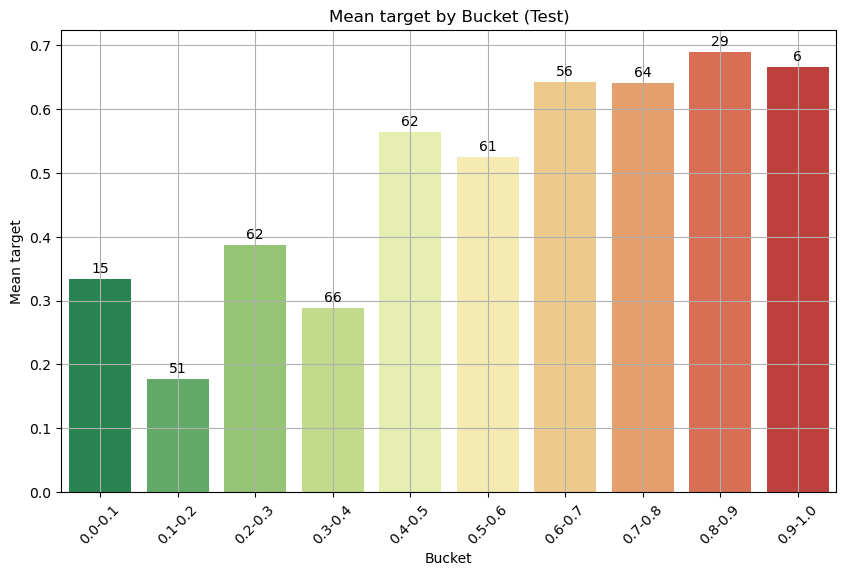

In [71]:
# Calculate decile statistics
decile_stats = df[df['sample'] == 'test'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'),
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}",
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (Test)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()

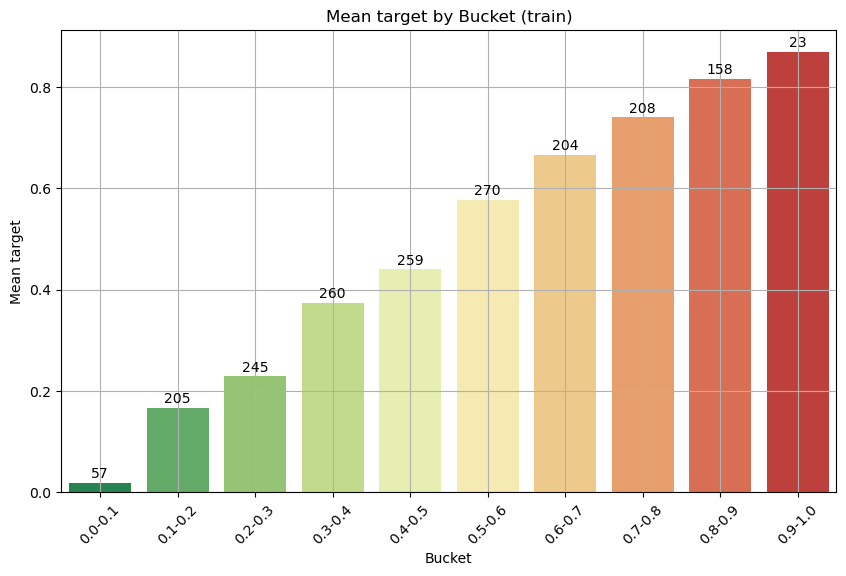

In [72]:
decile_stats = df[df['sample'] == 'train'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'), 
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}", 
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (train)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Kolmogorov-Smirnov

In [73]:
def plot_ks_curve(target, prediction):
    """
    Plots a normalized Kolmogorov-Smirnov (KS) curve for a classification model,
    highlighting the point where the KS statistic reaches its maximum.

    Args:
        target: A numpy array of true labels (0 or 1).
        prediction: A numpy array of predicted probabilities (between 0 and 1).
        threshold: The probability threshold to highlight on the plot.

    Returns:
        None
    """

    # Sort data by predicted probability
    sorted_idx = np.argsort(prediction)  # Sort in ascending order
    sorted_target = target[sorted_idx]
    sorted_prediction = prediction[sorted_idx]

    # Calculate cumulative distribution functions (CDFs) for positive and negative classes
    cum_pos = np.cumsum(sorted_target) / np.sum(sorted_target)
    cum_neg = np.cumsum(1 - sorted_target) / np.sum(1 - sorted_target)

    # Calculate the KS statistic (maximum difference between CDFs)
    ks_stat = np.max(np.abs(cum_pos - cum_neg))
    max_ks_idx = np.argmax(np.abs(cum_pos - cum_neg))
    max_ks_prob = sorted_prediction[max_ks_idx]

    # Plot the KS curve
    plt.plot(sorted_prediction, cum_pos, label='Positive Class')
    plt.plot(sorted_prediction, cum_neg, label='Negative Class')
    plt.axvline(x=max_ks_prob, color='g', linestyle='--', label=f'Max KS: {max_ks_prob:.2f}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Cumulative Probability')
    plt.title('KS Curve (KS Statistic: {:.3f})'.format(ks_stat))
    plt.legend()
    plt.grid(True)
    plt.show()

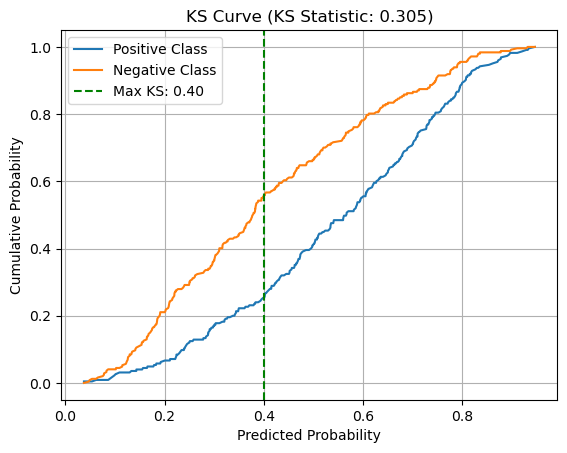

In [74]:
plot_ks_curve(df[df['sample'] == 'test'][TARGET].values, 
              df[df['sample'] == 'test']['y_pred'].values)

In [75]:
bin_edges = np.linspace(0, 1, 11)  # 10 equal-length intervals from 0 to 1
decile_labels = [f"{round(left, 2)}-{round(right, 2)}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]
df['decile'] = pd.cut(df['y_pred'], bins=bin_edges, labels=decile_labels, include_lowest=True)

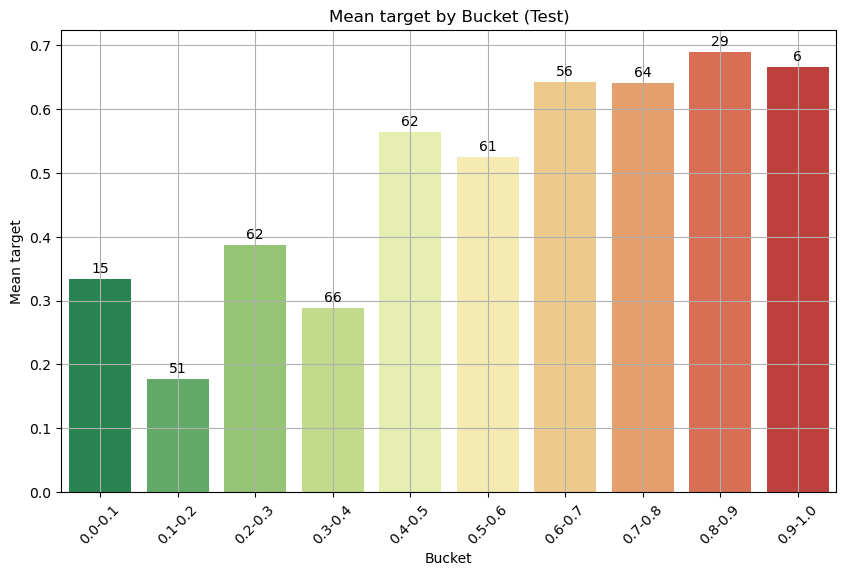

In [76]:
# Calculate decile statistics
decile_stats = df[df['sample'] == 'test'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'),
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}",
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (Test)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()

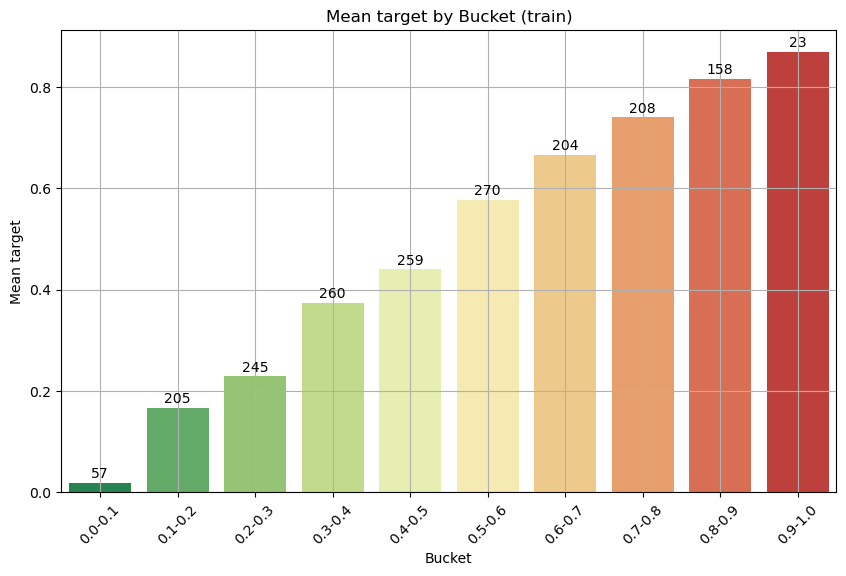

In [77]:
decile_stats = df[df['sample'] == 'train'].groupby('decile', observed=False).agg(
    mean_target=(TARGET, 'mean'), 
    count=(TARGET, 'size')
).reset_index()

# Clean the data to avoid NaN or infinite values
decile_stats_cleaned = decile_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=decile_stats_cleaned, x='decile', y='mean_target', palette="RdYlGn_r")

# Add the count of objects above each bar
for index, row in decile_stats_cleaned.iterrows():
    plt.text(index, row['mean_target'] + 0.01, f"{int(row['count'])}", 
             color='black', ha="center")

# Customize plot appearance
plt.title(f'Mean {TARGET} by Bucket (train)')
plt.xlabel(f'Bucket')
plt.ylabel(f'Mean {TARGET}')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [78]:
def plot_ks_curve(target, prediction):
    """
    Plots a normalized Kolmogorov-Smirnov (KS) curve for a classification model,
    highlighting the point where the KS statistic reaches its maximum.

    Args:
        target: A numpy array of true labels (0 or 1).
        prediction: A numpy array of predicted probabilities (between 0 and 1).
        threshold: The probability threshold to highlight on the plot.

    Returns:
        None
    """

    # Sort data by predicted probability
    sorted_idx = np.argsort(prediction)  # Sort in ascending order
    sorted_target = target[sorted_idx]
    sorted_prediction = prediction[sorted_idx]

    # Calculate cumulative distribution functions (CDFs) for positive and negative classes
    cum_pos = np.cumsum(sorted_target) / np.sum(sorted_target)
    cum_neg = np.cumsum(1 - sorted_target) / np.sum(1 - sorted_target)

    # Calculate the KS statistic (maximum difference between CDFs)
    ks_stat = np.max(np.abs(cum_pos - cum_neg))
    max_ks_idx = np.argmax(np.abs(cum_pos - cum_neg))
    max_ks_prob = sorted_prediction[max_ks_idx]

    # Plot the KS curve
    plt.plot(sorted_prediction, cum_pos, label='Positive Class')
    plt.plot(sorted_prediction, cum_neg, label='Negative Class')
    plt.axvline(x=max_ks_prob, color='g', linestyle='--', label=f'Max KS: {max_ks_prob:.2f}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Cumulative Probability')
    plt.title('KS Curve (KS Statistic: {:.3f})'.format(ks_stat))
    plt.legend()
    plt.grid(True)
    plt.show()

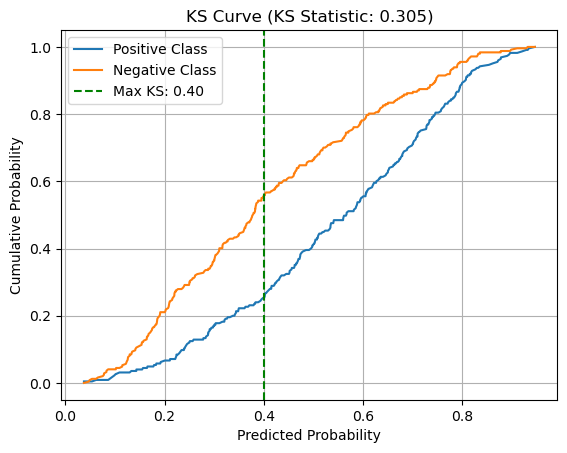

In [79]:
plot_ks_curve(df[df['sample'] == 'test'][TARGET].values, 
              df[df['sample'] == 'test']["y_pred"].values)

In [80]:
# features names
model_features_lst = pipeline_model.steps[-1][1].features_lst

In [81]:
df_features = pipeline_data.transform(
    X=df
)
df_features['sample'] = df['sample']
df_features[TARGET] = df[TARGET]

2025-12-17 23:37:00 - INFO - Simple features - Successfully finished.
2025-12-17 23:37:00 - INFO - Rare categories encoder - transform done.
2025-12-17 23:37:00 - INFO - Cat. binning - tranfsorm done.


Feature: num__loan_num, Bins: [0.0, 3.5, 7.5, 11.5, inf]
Feature: num__num_collection, Bins: [0.0, 2.5, 5.5, 9.5, inf]
Feature: num__non_null_default_reason_count, Bins: [0.0, 4.5, 8.5, inf]
Feature: num__keptpromise_ratio, Bins: [0.002436343914171498, 0.10821039229631424, 0.2050863578915596, 0.2906852811574936, inf]
Feature: num__ptp_amount_paid_ratio, Bins: [0.001850226570180785, 0.12187384441494942, 0.41335245966911316, inf]
Feature: num__total_payment, Bins: [897.5103946517564, 9450.314453125, 13156.54443359375, 20350.7412109375, inf]
Feature: num__total_number_of_payments, Bins: [0.0, 2.5, 6.5, inf]
Feature: num__total_contact_flag, Bins: [0.0, inf]
Feature: num__total_contact_flag_coll, Bins: [0.0, inf]
Feature: num__days_since_last_payment, Bins: [1.0, 50.5, 88.5, 146.5, inf]
Feature: num__promised_amount, Bins: [459.40390902683276, 4610.425537109375, 7220.6455078125, 10276.45361328125, inf]
Feature: num__paid_promised_amount, Bins: [-1.0, inf]
Feature: num__number_of_kept_promi

2025-12-17 23:37:01 - INFO - Num. binning - tranfsorm done.


Feature: num__days_past_due, Bins: [1.0, 11.5, 17.5, 22.5, inf]
Feature: num__loan_balance, Bins: [-1.0, inf]
Feature: num__daily_arrearsprincipal, Bins: [235.29119951632651, 3372.8594970703125, 7860.36572265625, 13008.060546875, inf]
Feature: num__daily_arrearsinterest, Bins: [92.41374985477323, 1276.5184326171875, 2668.067138671875, 6896.3564453125, inf]
Feature: num__daily_penaltydue, Bins: [38.491798092392884, 1219.6722412109375, 2143.90673828125, 3817.3685302734375, inf]
Feature: num__application.renMaxDPD, Bins: [1.0, 81.5, 113.5, inf]
Feature: num__salary_median, Bins: [5733.940798326002, 17582.830078125, 24045.6279296875, 40598.5078125, inf]
Feature: num__cb_avg.outstandingloan, Bins: [5102.745339729954, 21119.7734375, 26348.384765625, 45729.16796875, inf]
Feature: num__cb_avg.totalMonthlyInstallments, Bins: [1678.9658062013011, 22356.6357421875, inf]
Feature: num__cb_avg.currentDPD, Bins: [1.0, 51.5, 82.5, inf]
Feature: num__cb_avg.maxDPD, Bins: [1.0, 53.5, 84.5, 123.5, inf]
F

/home/jovyan/.local/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) num__total_payment__bin, num__salary_median__bin.
  warnings.warn(
2025-12-17 23:37:01 - INFO - WOE cat encoder - transform done.
2025-12-17 23:37:01 - INFO - Feature elimination - selected features count:   38.
2025-12-17 23:37:01 - INFO - Feature elimination - transform done.


## Corr matrix

In [82]:
corr_matrix = df_features[df_features['sample'] == 'train'][model_features_lst].corr()

<AxesSubplot:>

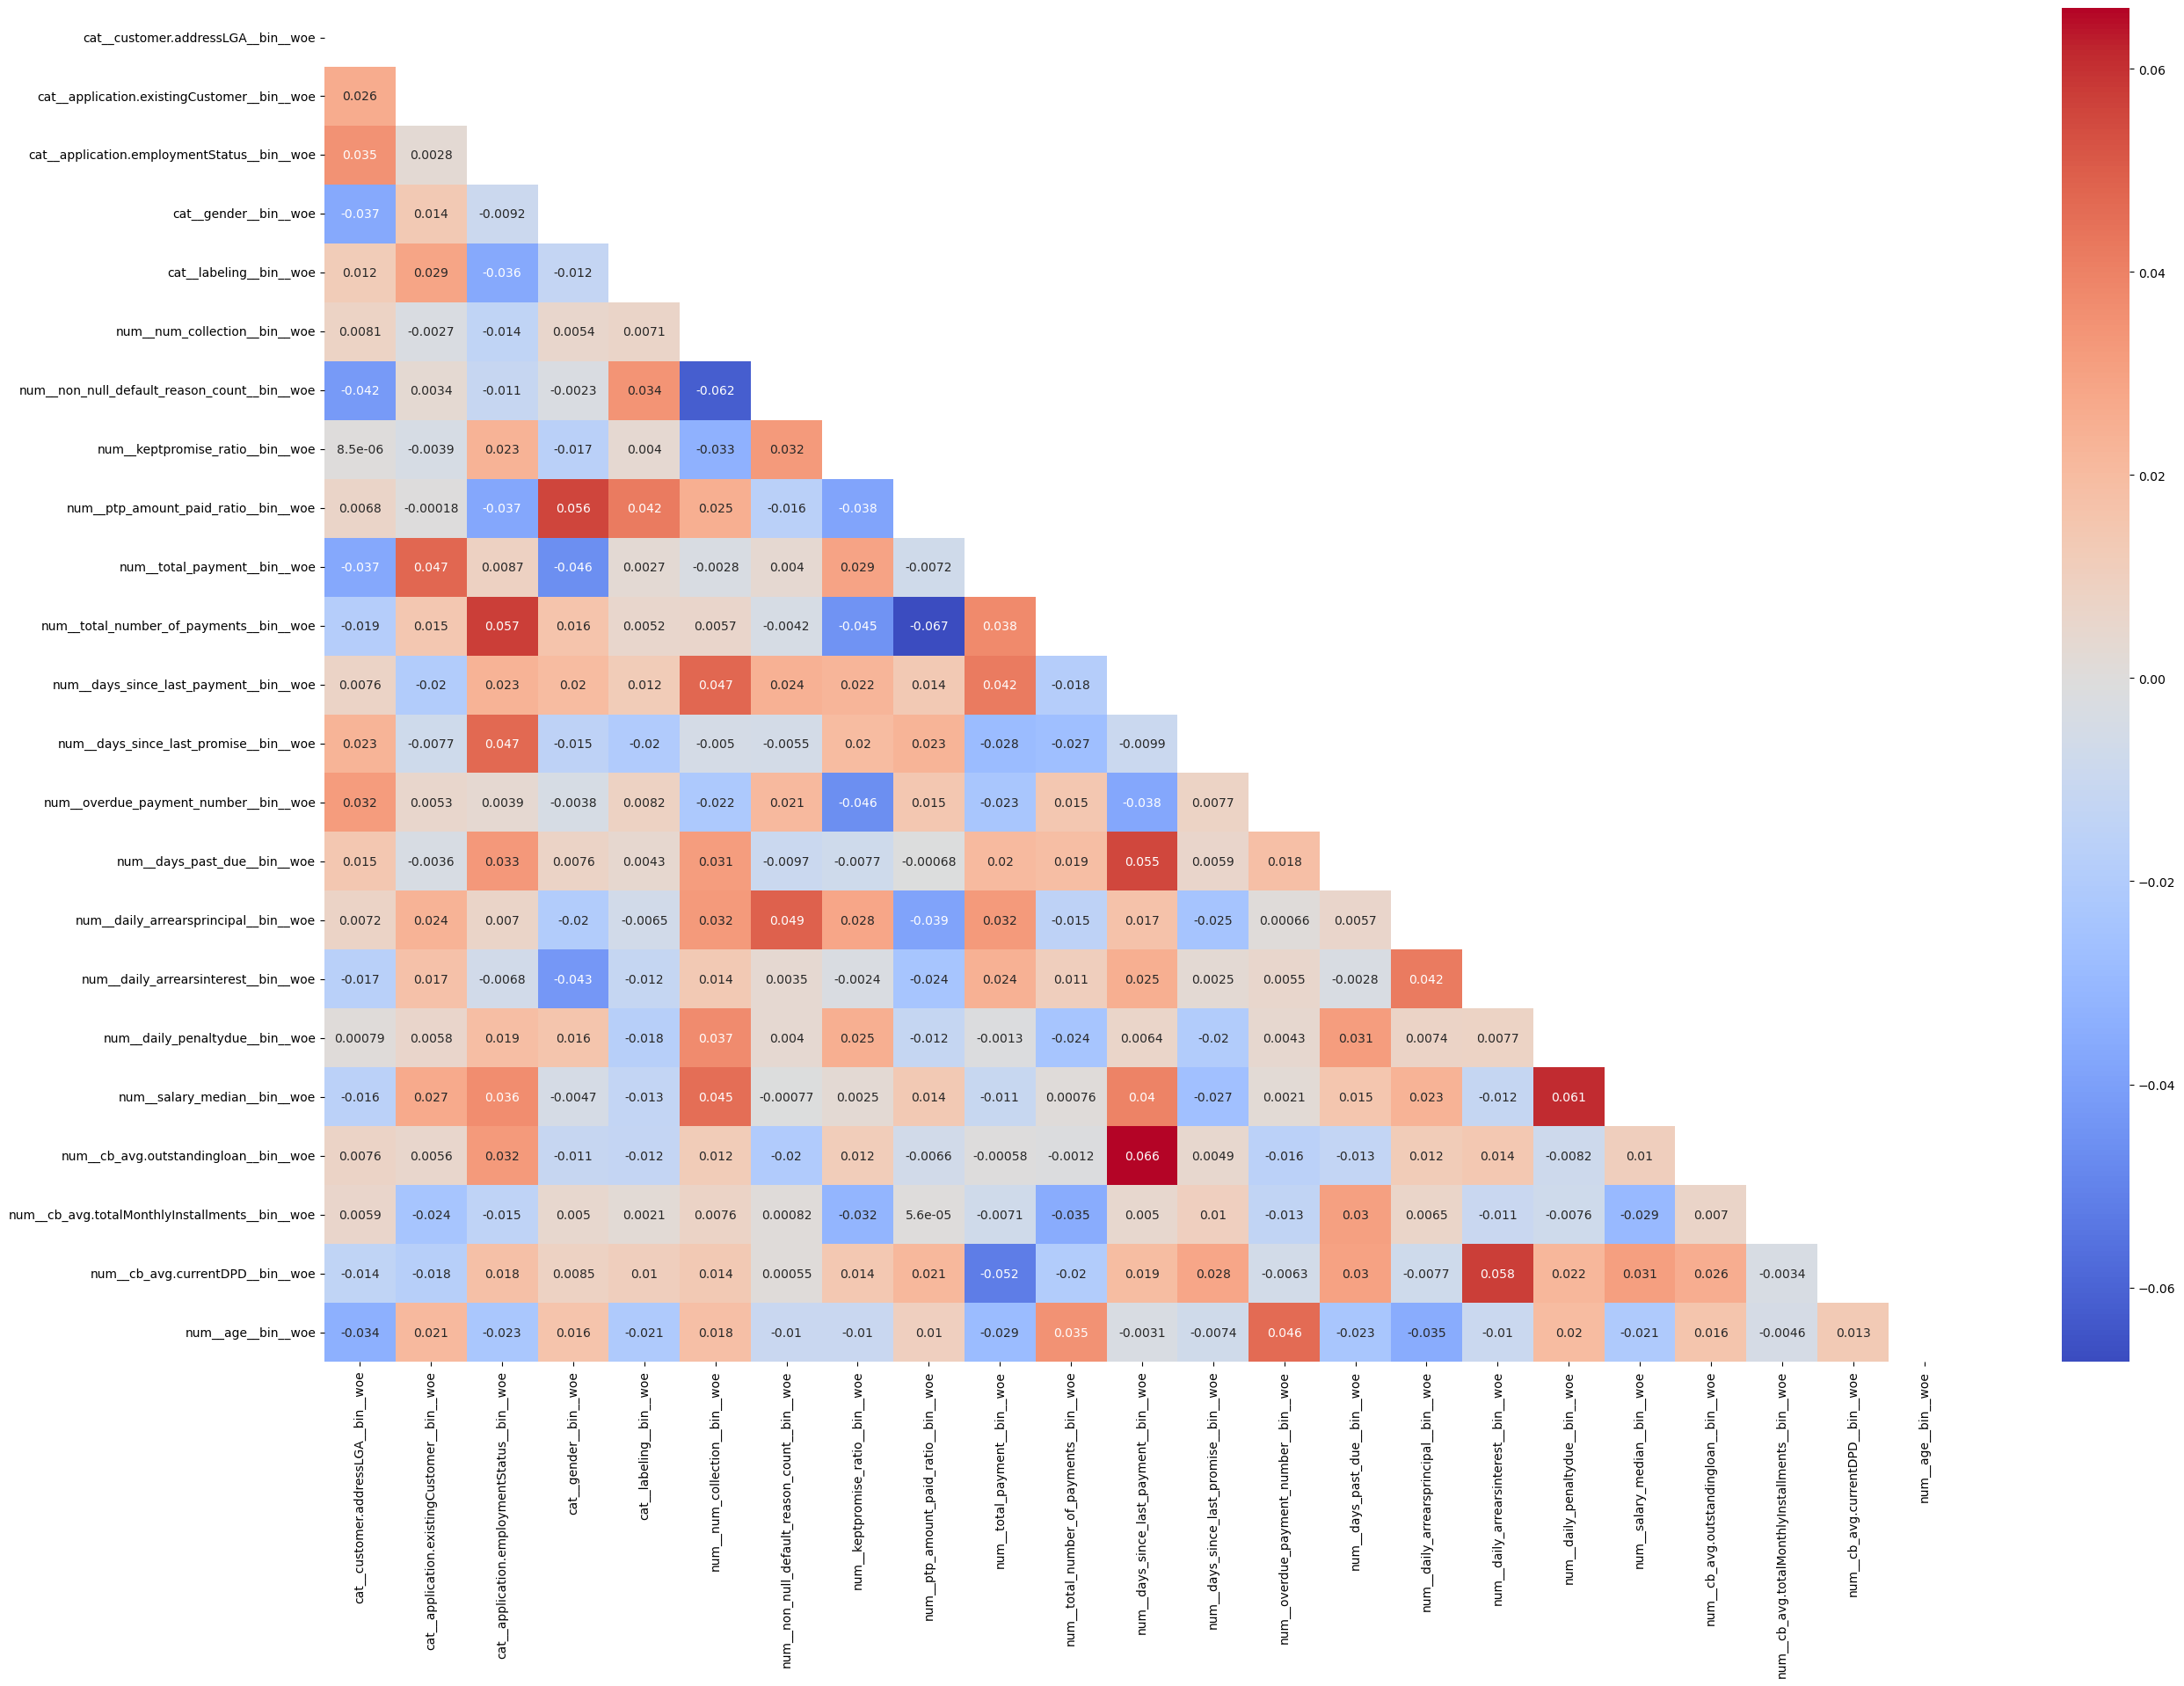

In [83]:
plt.figure(figsize=(30,20))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)

## Merge features 

In [84]:
df.head().T

,1,2,4,5,6
loan_id,43,50,72,77,135
snap_date,2025-02-22 00:00:00,2025-03-22 00:00:00,2025-02-10 00:00:00,2025-03-12 00:00:00,2025-03-16 00:00:00
loan_name,Product_C,Product_C,Product_C,Product_C,Product_C
customer.addressLGA,LGA_5,LGA_1,LGA_3,LGA_4,LGA_3
customer.employment.employerLGA,LGA_4,LGA_5,LGA_5,LGA_2,LGA_4
customer.employment.businessSector,Services,Other,Other,Public,Other
application.existingCustomer,Y,N,N,Y,Y
application.loanType,Type_3,Type_2,Type_3,Type_2,Type_3
application.lastLoanStatus,Paid,Paid,Unknown,Active,Paid
application.employmentSector,Retail,Other,Services,Other,Public


## Feature summary 

In [87]:
model_coeff_df = pipeline_model.steps[6][1].estimator.params.to_frame(name='Coeff')
model_coeff_df = model_coeff_df.rename_axis("Feature").reset_index()
model_coeff_df.columns = ["Feature", "Coeff"]

In [88]:
model_coeff_df

,Feature,Coeff
0,const,-0.095982
1,cat__customer.addressLGA__bin__woe,1.040415
2,cat__application.existingCustomer__bin__woe,1.072434
3,cat__application.employmentStatus__bin__woe,1.086355
4,cat__gender__bin__woe,1.171658
5,cat__labeling__bin__woe,0.951369
6,num__num_collection__bin__woe,0.959083
7,num__non_null_default_reason_count__bin__woe,1.003346
8,num__keptpromise_ratio__bin__woe,1.292016
9,num__ptp_amount_paid_ratio__bin__woe,1.082052


In [89]:
pearson_corr_df = df_report[model_features_lst + [TARGET]].corr()[[TARGET]].rename(columns={TARGET: 'Importance indicator (Pearson corr with target)'})
pearson_corr_df = pearson_corr_df.rename_axis("Feature").reset_index()
pearson_corr_df.columns = ["Feature", "Importance indicator"]

In [90]:
pearson_corr_df

,Feature,Importance indicator
0,cat__customer.addressLGA__bin__woe,0.057428
1,cat__application.existingCustomer__bin__woe,0.091149
2,cat__application.employmentStatus__bin__woe,0.178270
3,cat__gender__bin__woe,0.070190
4,cat__labeling__bin__woe,0.048151
5,num__num_collection__bin__woe,0.055925
6,num__non_null_default_reason_count__bin__woe,0.060153
7,num__keptpromise_ratio__bin__woe,0.056392
8,num__ptp_amount_paid_ratio__bin__woe,0.034899
9,num__total_payment__bin__woe,0.022953


In [91]:
iv_train = calculate_information_values(df_report[df_report['sample'] == 'train'], 
                                        significant_features_list, 
                                        TARGET)
iv_train.rename(columns={"IV": "train IV"}, inplace=True)

iv_test = calculate_information_values(df_report[df_report['sample'] == 'test'], 
                                       significant_features_list, 
                                       TARGET)
iv_test.rename(columns={"IV": "test IV"}, inplace=True)

In [92]:
iv = pd.merge(iv_train, iv_test, on="Feature", how="inner")
coeff_iv = pd.merge(model_coeff_df, iv, on="Feature", how="outer")
final = pd.merge(coeff_iv, pearson_corr_df, on="Feature", how="outer")

final.sort_values(by="Importance indicator", ascending=False, inplace=True)
final = final[~final['Feature'].isin(['const', 'target'])]

final

,Feature,Coeff,train IV,test IV,Importance indicator
12,num__days_since_last_payment__bin__woe,1.031757,0.377395,0.383986,0.299034
3,cat__application.employmentStatus__bin__woe,1.086355,0.146256,0.079761,0.178270
2,cat__application.existingCustomer__bin__woe,1.072434,0.036862,0.021551,0.091149
11,num__total_number_of_payments__bin__woe,1.141860,0.028774,0.040663,0.086617
23,num__age__bin__woe,1.247763,0.036380,0.025860,0.074036
15,num__days_past_due__bin__woe,0.983152,0.021566,0.067746,0.073252
4,cat__gender__bin__woe,1.171658,0.017118,0.032194,0.070190
7,num__non_null_default_reason_count__bin__woe,1.003346,0.016722,0.016540,0.060153
17,num__daily_arrearsinterest__bin__woe,1.082626,0.013412,0.033066,0.058506
1,cat__customer.addressLGA__bin__woe,1.040415,0.018093,0.043499,0.057428
